In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from astropy.io import fits

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Define general paths 

In [5]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


Define also the spectral types 

In [7]:
spectral_types = ['O','B','A','F','G','K','M']

# Select a spectral atlas 

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [8]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [9]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

File Type      Teff     Name
0      pickles_uk_1.fits  O5V  39810.70  unknown
1      pickles_uk_2.fits  O9V  35481.40  unknown
2      pickles_uk_3.fits  B0V  28183.80  unknown
3      pickles_uk_4.fits  B1V  22387.20  unknown
4      pickles_uk_5.fits  B3V  19054.60  unknown
..                   ...  ...       ...      ...
126  pickles_uk_127.fits  G8I   4591.98  unknown
127  pickles_uk_128.fits  K2I   4255.98  unknown
128  pickles_uk_129.fits  K3I       NaN  unknown
129  pickles_uk_130.fits  K4I   3990.25  unknown
130  pickles_uk_131.fits  M2I   3451.44  unknown

[131 rows x 4 columns]

# Load with pysynphot the spectra from the selected atlas 

In [10]:
sed_list = np.array(atlas_seds['File'])

In [11]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

Check the spectra were correctly loaded 

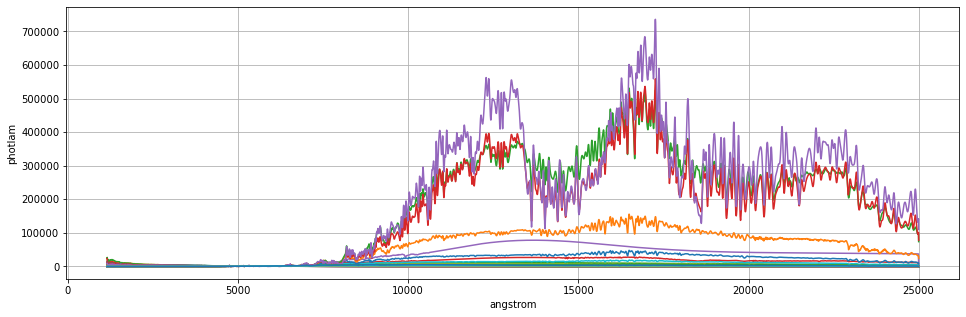

In [12]:
fig=plt.figure(figsize=(16,5))
for sed_ in sed_dict.keys():
    spec = sed_dict[sed_]
    spec.convert('photlam')
    plt.plot(spec.wave,spec.flux)
    plt.xlabel(spec.waveunits)
    plt.ylabel(spec.fluxunits)
    #plt.xlim((0,10000))
    plt.grid()


Let's organise spectra by spectral type 

In [13]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [14]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

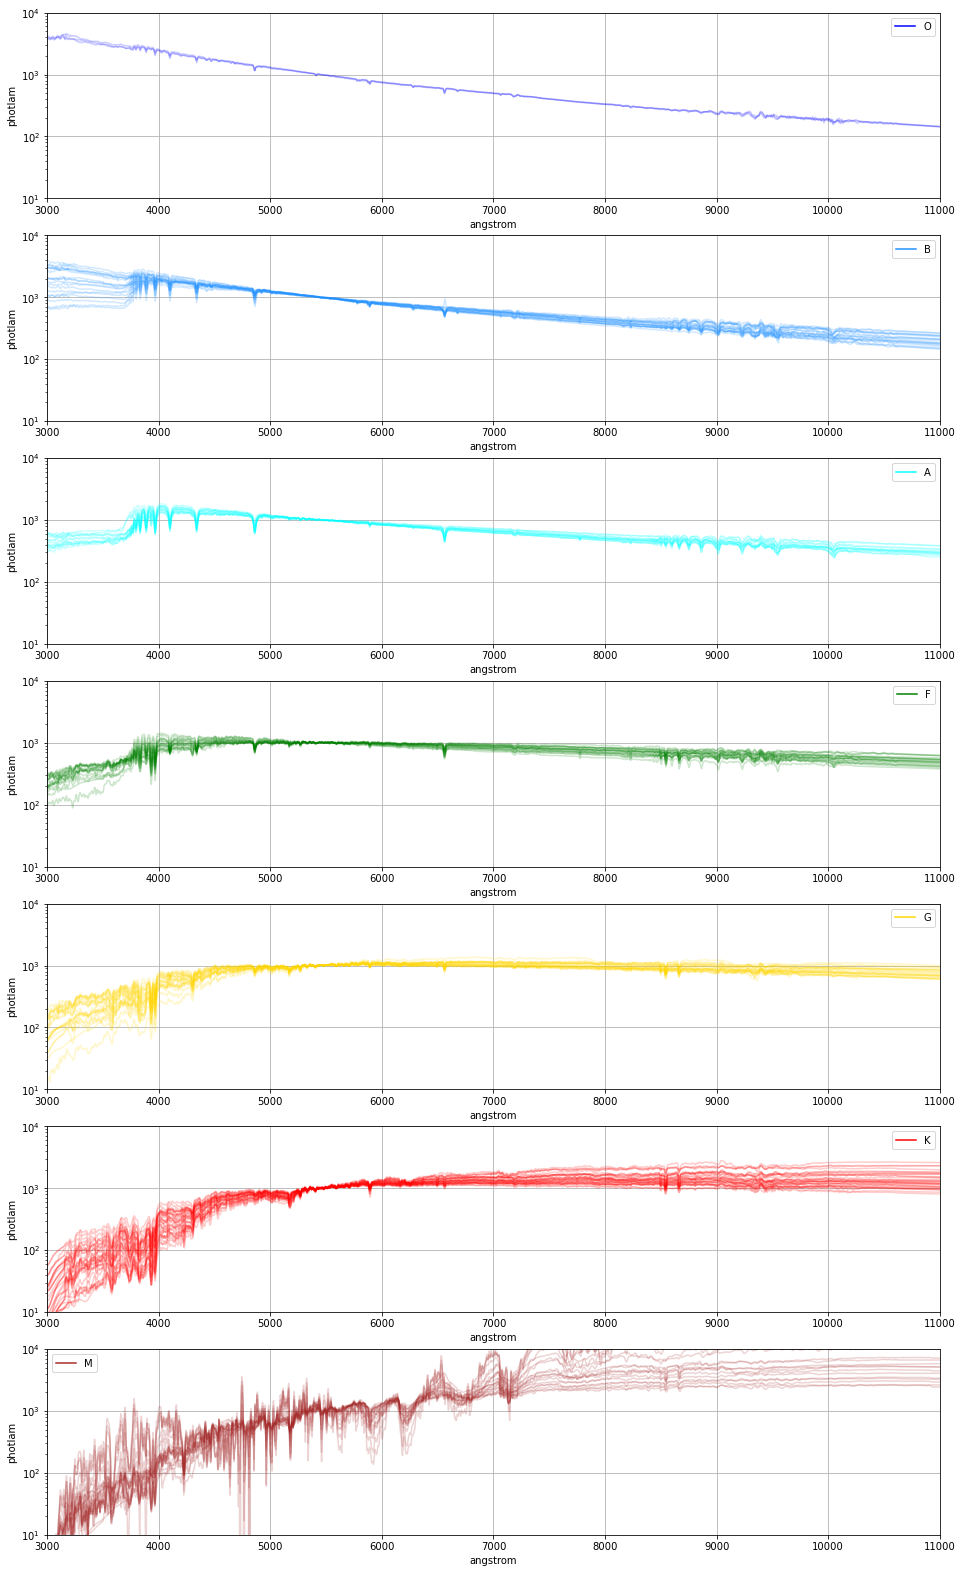

In [15]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(spec.waveunits)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Load LSST transmissions file 

In [16]:
datafilename = "data/lsst/old/transmissions-LSST.dat"
df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [17]:
wl=df['wl'].values
U=df['U'].values/100.
G=df['G'].values/100.
R=df['R'].values/100.
I=df['I'].values/100.
Z=df['Z'].values/100.
Y4=df['Y4'].values/100.

lsst_bp = []
lsst_bp.append(S.ArrayBandpass(wl*10, U , name="u"))
lsst_bp.append(S.ArrayBandpass(wl*10, G , name="g"))
lsst_bp.append(S.ArrayBandpass(wl*10, R , name="r"))
lsst_bp.append(S.ArrayBandpass(wl*10, I , name="i"))
lsst_bp.append(S.ArrayBandpass(wl*10, Z , name="z"))
lsst_bp.append(S.ArrayBandpass(wl*10, Y4 , name="Y"))

In [18]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

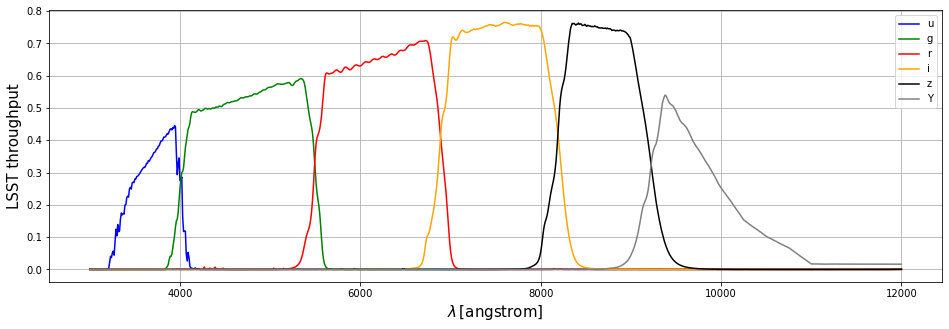

In [19]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

We find a leakage at higher wavelengths for some filters that impacts the colour values of the M type stars 

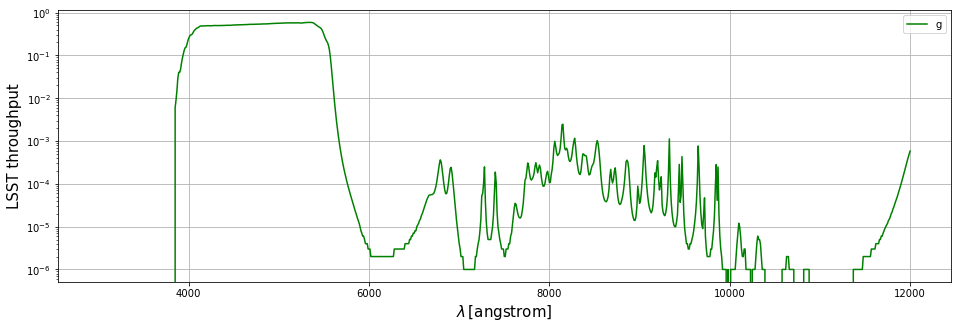

In [20]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
index=1
ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
ax.set_yscale("log")
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

Let's try with a more updated version of the throughputs. We are given only the total passband and the atmosphere that was used to generate them (https://github.com/lsst/throughputs/tree/main/baseline), so in order to have the throughputs we need to divide the passbands by this atmosphere 

In [21]:
total_passband_path = 'data/lsst/'
total_passband_label = 'total_{0}.dat'
atm_lsst_file = 'atmos_std.dat'

In [22]:
atm_lsst = np.loadtxt(total_passband_path+atm_lsst_file)

Now, we write the passbands in pysynphot format: 

In [23]:
wl = atm_lsst[:,0]*10.

lsst_bp = []
for f in filters:
    passband_ = np.loadtxt(total_passband_path+total_passband_label.format(f.lower()))
    assert (atm_lsst.shape==passband_.shape)
    throughput_ = passband_[:,1]/atm_lsst[:,1]
    lsst_bp.append(S.ArrayBandpass(wl, throughput_ , name=f))



/tmp/ipykernel_29280/1969671528.py:7: RuntimeWarning: invalid value encountered in true_divide
  throughput_ = passband_[:,1]/atm_lsst[:,1]


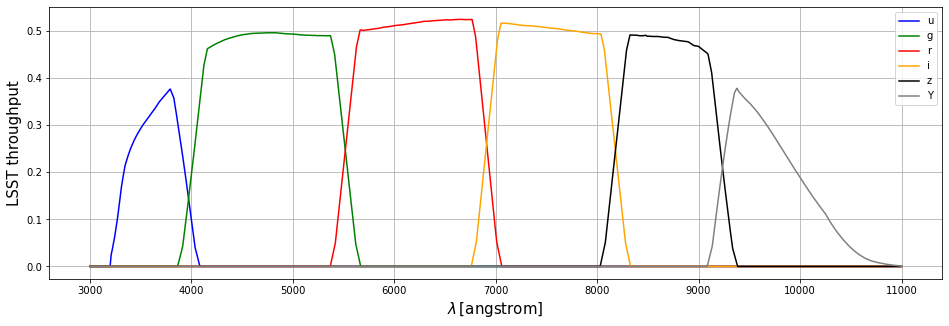

In [24]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()
plt.savefig(os.path.join(outdir_plots0,'LSST_throughputs.png'))

In [25]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [26]:
wl_lsst = lsst_bp[0].wave

# Compare with hardware.dat 

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [27]:
variable_param = 'aerosol'
am0 = 1.2
cloud0 = 0.0

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [28]:
param_dist = 'linear_distribution-discrete'

In [29]:
outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [30]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [31]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [32]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [33]:
wl_t = data[0][n_atmp:]*10.

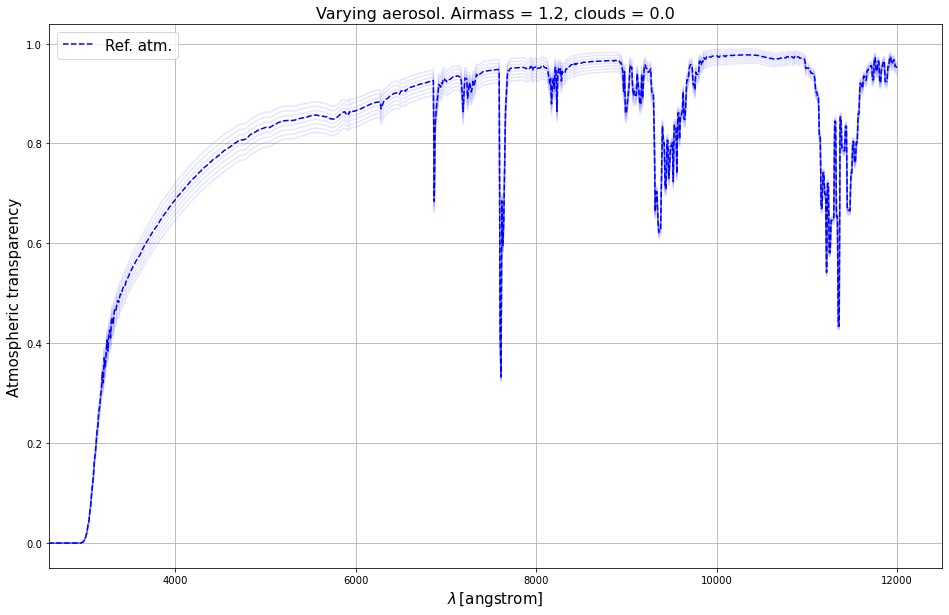

In [34]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of simulated atm values

In [35]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [36]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [37]:
var_index = params_index[variable_param]

In [38]:
#data[1:,1]
data[1:,var_index]

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

(array([0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0.]),
 array([-0.5       , -0.41666667, -0.33333333, -0.25      , -0.16666667,
        -0.08333333,  0.        ,  0.08333333,  0.16666667,  0.25      ,
         0.33333333,  0.41666667,  0.5       ]),
 <a list of 12 Patch objects>)

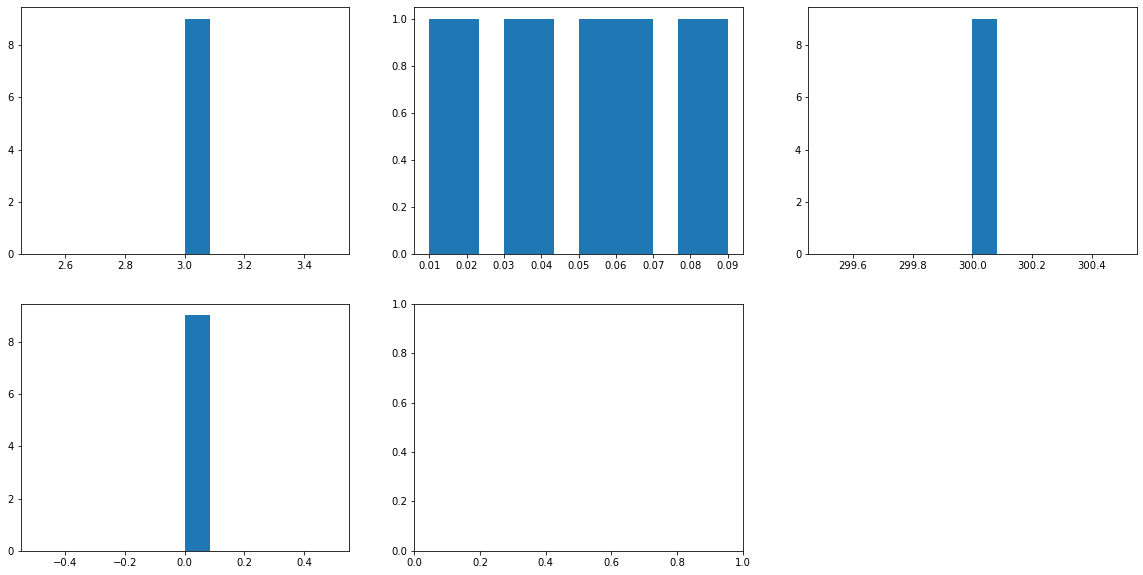

In [39]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)

ax1.hist(data[1:,0],bins=12)
ax2.hist(data[1:,1],bins=12)
ax3.hist(data[1:,2],bins=12)
ax4.hist(data[1:,3],bins=12)

# Select data for variable parameter of these simulations 

In [40]:
atm_vals = data[1:,var_index]

In [41]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [42]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [43]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [44]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [45]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [46]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


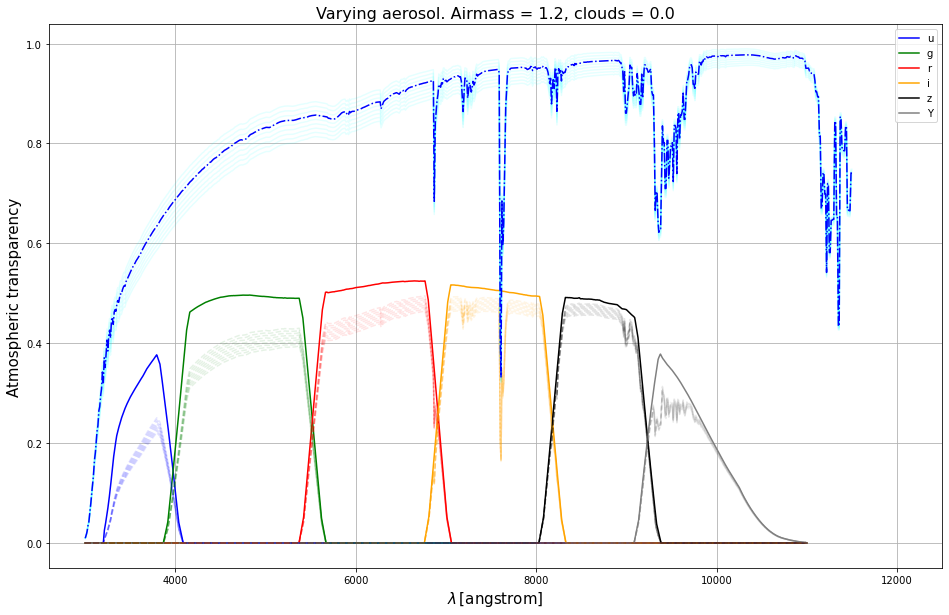

In [47]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [48]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

0.01 0.09


In [49]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [50]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

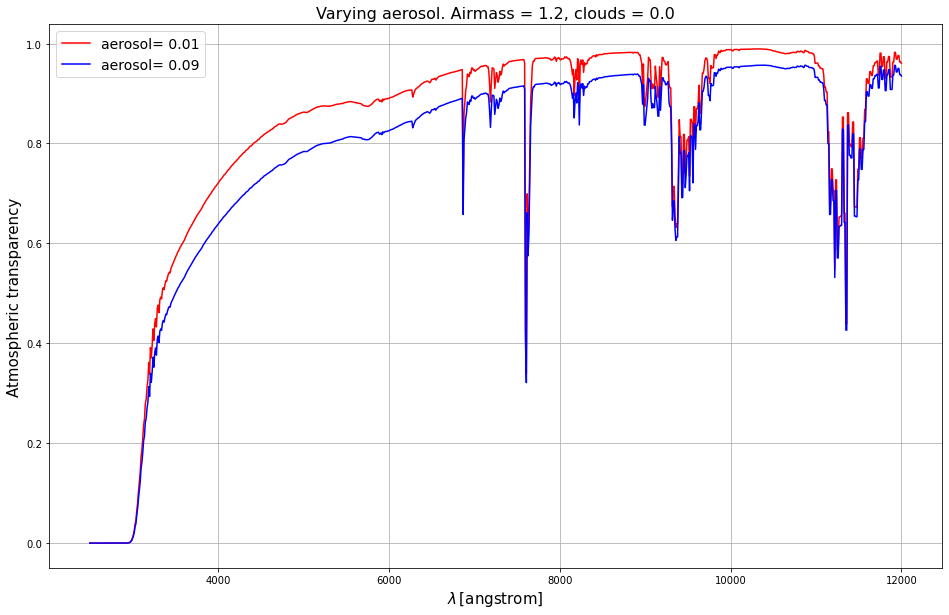

In [51]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [52]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]

In [53]:
# It seems this galaxy is a small enough place to end up choosing again, just by coincidence, Vega as example star 
vega = S.Vega
vega.convert('photlam')

photlam


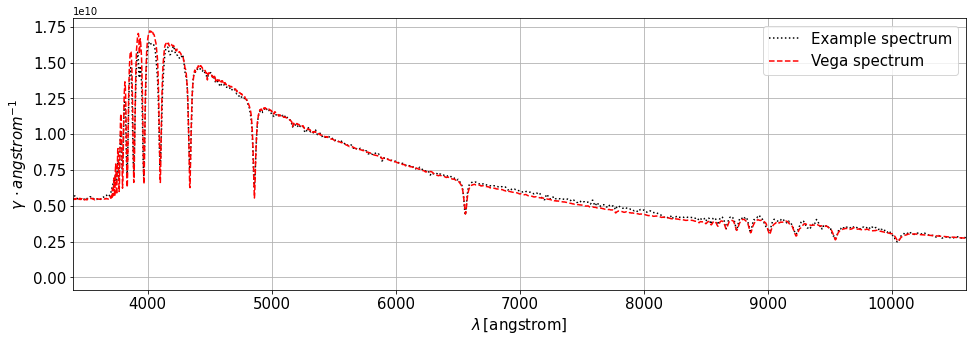

In [54]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0,label='Example spectrum')
plt.plot(vega.wave,vega.flux*Seff*exptime,ls='--',color='r',alpha=1.0,label='Vega spectrum')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(example_spec.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

Let's make the example spectrum pass through the atmosphere and through the total passband (atm. x throughput) 

In [55]:
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(example_spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter].append(obstotal)

(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 3) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 4) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 5) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 6) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 7) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 8) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined

u
g
r
i
z
Y
photlam


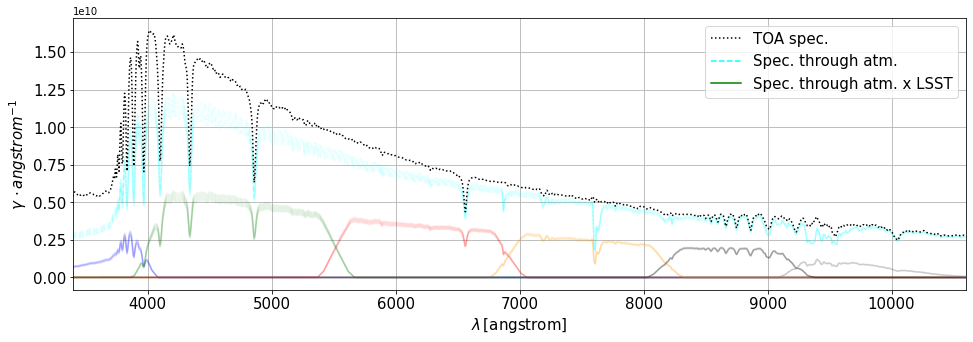

In [56]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    obsatm = obsatm_dict[isim]
    ax.plot(obsatm.binwave,obsatm.binflux*Seff*exptime,ls='--',color='cyan',alpha=0.07)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls=':',color='k',label='TOA spec.')
plt.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

This was an example of how the spectrum looks like when passing only through the atmosphere and through the total passbands. For our calibration purposes, what we actually want is to have the spectra passing through either only the troughput (as if the telescope was on space) and through the total passband (ground-based telescope). Now let's pass all spectra through the throughput and through the atmosphere 

In [57]:
# Spectra through atm x throughput 
obs_dict = {}
#for sed_ in list(sed_dict.keys()):
for st in spectral_types:
    print(st)
    obs_dict_ = {}
    for si,spec in enumerate(spec_by_type[st]):
        filter_dict_ = {}
        for filter in filters:
            filter_dict_[filter] = []
            for i in range(n_sim):
                obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
                filter_dict_[filter].append(obs_spec)
        obs_dict_[si] = filter_dict_ 
    obs_dict[st] = obs_dict_


O
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [58]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(obs_dict[test_type].keys()))
#print(len(obs_dict[example_spec].keys()))
print(len(obs_dict[test_type][test_spec].keys()))
print(len(obs_dict[test_type][test_spec]['u']))
print(n_sim)

131
7
13
6
9
9


In [59]:
# Spectra only through throughput (as if telescope was in space) 
obs_dict_t = {}
for st in spectral_types:
    print(st)
    obs_dict_t_ = {}
    for si,spec in enumerate(spec_by_type[test_type]):
        filter_dict_ = {}
        for filter in lsst_bp:
            obs_spec_t = S.Observation(spec,filter,force='taper')
            filter_dict_[filter.name] = obs_spec_t
        obs_dict_t_[si] = filter_dict_ 
    obs_dict_t[st] = obs_dict_t_
    

O
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in

In [60]:
print(len(sed_dict.keys()))
print(len(obs_dict_t.keys()))
print(len(obs_dict_t[test_type].keys()))
print(len(obs_dict_t[test_type][test_spec].keys()))

131
7
13
6


In [61]:
obs_dict_t[test_type][0]['u']

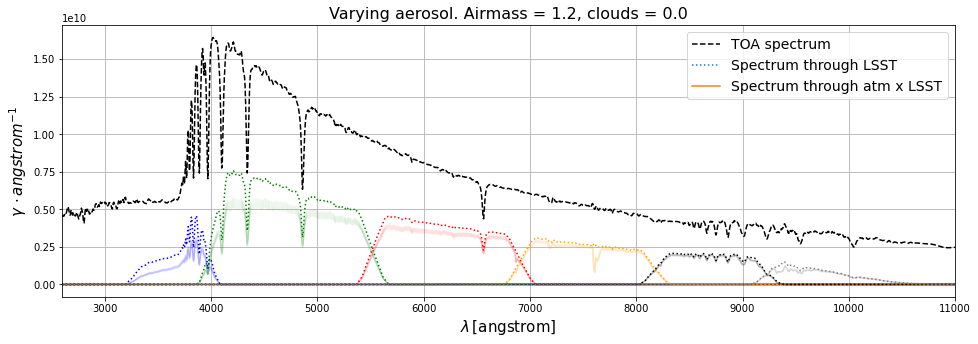

In [62]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
spec_by_type[test_type][test_spec].convert('photlam')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(obs_dict_t[test_type][test_spec][filter].wave,obs_dict_t[test_type][test_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = obs_dict[test_type][test_spec][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Calculate magnitudes with my own function 

Physical constants 

In [63]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [64]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [65]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [66]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [67]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

In [68]:
def myAB(spec,passband,filter):
    f_units = str(spec.fluxunits)
    if f_units!='flam':
        print('ATTENTION: converting flux units to flam')
        spec.convert('flam')
        
    observation = S.Observation(spec,passband,force='taper')
    nan_mask = np.isnan(observation.flux)
    
    num = np.trapz(observation.flux[~nan_mask]/observation.wave[~nan_mask],x=observation.wave[~nan_mask])
    #obmag = -2.5*np.log10(num)
    
    spec.convert('photlam')
    
    #print(num)
    
    #flatsp = S.FlatSpectrum(f_ref,fluxunits='fnu')
    #flatsp_vals = np.ones(len(spec.wave))*f_ref
    #flatsp = S.ArraySpectrum(spec.wave,flatsp_vals)
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('flam')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    den = np.trapz(ab_obs.flux[~nan_mask]/ab_obs.wave[~nan_mask],x=ab_obs.wave[~nan_mask])
    
    #print(den)
    #print(num/den)
    #print(obmag)
    mab = -2.5*np.log10(num/den)
    print(mab)
    return mab

In [69]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(example_spec.wave)

In [70]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [71]:
flatsp.fluxunits

photlam


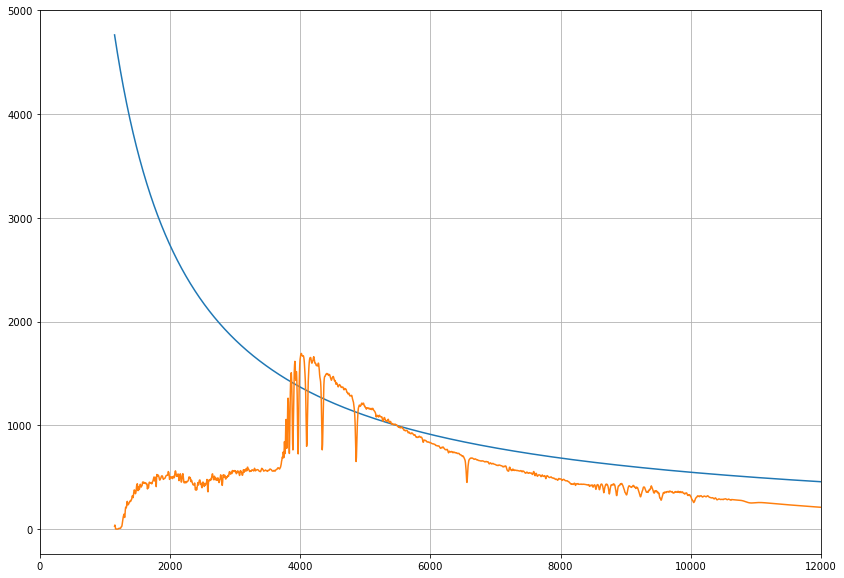

In [72]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)
plt.xlim(0.,12000.)
plt.grid()

In [73]:
flatsp0 = S.FlatSpectrum(f_ref,fluxunits='fnu')
flatsp0.fluxunits

Here we verify that creating a pysynphot AB flat spectrum and transforming it to photlam gives the same as directly creating the same spectrum in photlam units with ABnphot 

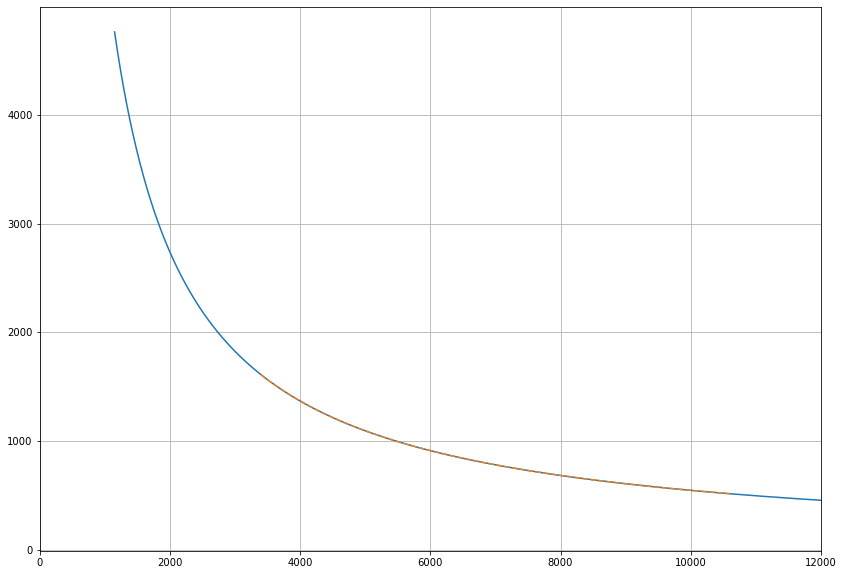

In [74]:
flatsp0.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(flatsp0.wave,flatsp0.flux,ls='--')
plt.xlim(0.,12000.)
plt.grid()

To further check it, let's transform it to flam and compare with the analytical expression: 

$$F_{\lambda} = F_{\nu} \frac{c}{\lambda^2}$$

In [75]:
flambda = f_ref*c_light/flatsp.wave**2.

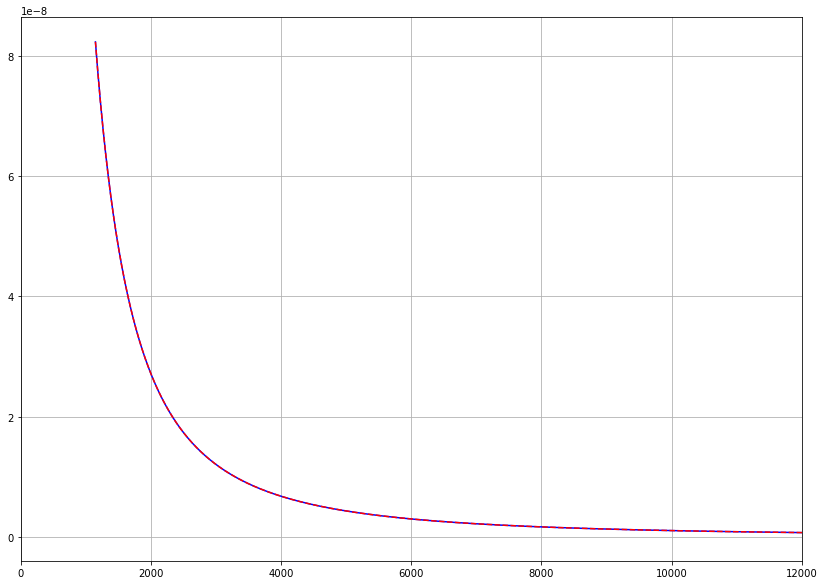

In [76]:
flatsp.convert('flam')
flatsp.waveunits
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp.wave,flambda,color='r',ls='--')
plt.xlim(0.,12000.)
plt.grid()
flatsp.convert('photlam')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [77]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of 

We check the same for the total passband. Note that, given the definition of AB magnitudes that we have implemented, the denominator only considers the throughput of the telescope, even when the spectra pass through the total passband, since the "reference" we want to compare to is when there is no effect of the atmosphere, but in any case the light passes through the telescope, so we consider the telescope's throughput to be the reference (i.e. as if it had a transmission = 1) with respect to which the flux is attenuated. Therefore, the following AB magnitudes of a flat AB spectrum should be different from (greater than) zero  

In [78]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5515615041792967
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21879995552010106
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11151715654857113
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. Th

Now, let's see the AB magnitudes of the example spectrum with myAB function. To better understand it, we can compare the AB spectrum and the example spectrum (Vega) flux amplitudes in each range of wavelengths (see plot below) 

photlam


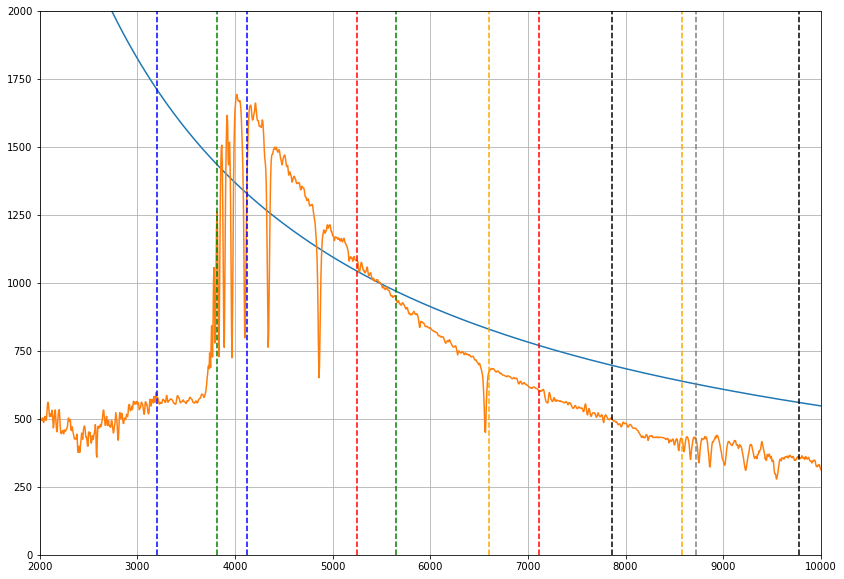

In [79]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])

plt.xlim(2000.,10000.)
plt.ylim(0.,2000.)
plt.grid()

In [80]:
for filter in lsst_bp:
    myAB(example_spec,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.765021086705792
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09951151871534347
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12690586603750892
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined 

In [81]:
for fi,filter in enumerate(filters):
    myAB(example_spec,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2740706033748663
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1210115312690285
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24018872230105734
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The

# Calculate magnitudes and colours

We compute the magnitudes for the spectra of each spectral type for each atmosphere 

In [82]:
# Magnitudes of spectra passing through atm x throughput 
mag_dict = {}
mag_dict_ref = {}
for st in spectral_types:
    print(st)
    
    mag_dict_st = {}
    mag_dict_ref_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        mag_dict_ = {}
        mag_dict_ref_ = {}
        for fi,filter in enumerate(filters):
            mag_dict_[filter] = []
            for i in range(n_sim):
                #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
                mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
                mag_dict_[filter].append(mag_ab_)
                
            #mag_dict[sed_] = mag_dict_
                    
            mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
            mag_dict_ref_[filter] = mag_ab_
        mag_dict_st[si] = mag_dict_
        mag_dict_ref_st[si] = mag_dict_ref_
    mag_dict[st] = mag_dict_st
    mag_dict_ref[st] = mag_dict_ref_st
        

O
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23025852662176266
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2124012869683103
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19454452705038155
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat tabl

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38288861336823715
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7020243675825387
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7096482773267372
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2722490122480634
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2452187957655751
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.14198593682499716
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.124138541

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.40343173305995295
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6995282176550631
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7071472921850435
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.71476618265

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3037534992507043
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3092752831068917
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2822805824341763
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.15371564476

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.394583982959252
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4047290057200273
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4148719977900033
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4250143565851

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.250176637600594
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.25527017176863
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2606067604935807
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.266135084506439

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3566993526940599
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.366683432074052
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3766668238239883
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3866495302992

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9278673793927137
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1644332758489528
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1695331553999309
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.174632913887

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06758660340758854
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08185469190117393
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.010397927907021405
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31678021

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8346596771225735
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8412809595703832
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8479020264298971
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.815318260150

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04681909204464417
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0610938668443203
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07533696579165035
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0895788125

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7720690227528182
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7394805129899451
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.970648779357709
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2916764352777108
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30163153570041135
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3115859449783253
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.32153966573

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6502050864833007
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8666533994758154
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8717448540729821
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.876836184385

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.164760293295876
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09362801857630543
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2492257792121451
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.259179576286

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6134243017056284
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5808830949889644
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7494367442534146
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.754520686967

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13321699129045106
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23732105763364045
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24726526873568996
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.257208782

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5655017926170689
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7433798571831469
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7484662942832122
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.014410951966648072
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.028715335760655145
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.042925338694903135
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.32317

1.0852035902383097
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0902935147908392
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0953833136524378
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.100472970441133
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29788380657760216
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30791764548320366
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3180236553109514
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3281276107

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8073531440315764
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7803814358931618
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06943240041285942
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08724406112

0.4135311429881461
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36309226892334223
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6227240258999643
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6303335170373134
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1330956406287287
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3883704894588113
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4061405391608848
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.423910095185

0.35392612763642295
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.548980496709191
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5565856638220072
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5641906448075499
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the 

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6472078820360655
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6649193443489686
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6826303443568216
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.700203378167

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4910322906709949
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.49863414788102345
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.506235819130167
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.513837320210

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918395500467086
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8648577973985881
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.056261751167687
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0738294946107

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28151445169250117
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4512285193178301
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.45883260864304765
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

0.19158580207018408
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20940619571877303
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22722610012831485
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24504554818919372
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in 

0.6064091451590304
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6140207455677114
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.621632196451558
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6294073443882086
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the w

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5608799841224329
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5784864548398991
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5959832430096547
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.613481738837

0.5657248475789018
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5736269620019039
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.581528845341308
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5424324393726867
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the w

0.17003959204006405
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08170626010612853
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.017970089664889593
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.003655839436080559
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8159425429609591
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8222009146308815
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8284591564878843
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.834717323987

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07176991685296616
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08601543910676261
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.10022998021144251
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.114443249

0.8036286670010127
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8102596188563096
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8168872935675979
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8235147526386283
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12328357280192911
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1375105061392535
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1517356246752011
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08049684054

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7454834621825757
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.752102817743532
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7195277399383639
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9394455697188

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20639761718784622
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13551854293629176
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.25365277400132674
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.263582815

0.7546060531183445
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7596974688812379
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7647887597967484
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.769879908776306
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27166901318181486
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2815993286689391
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2915289477959038
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30155054157

0.6565093169615024
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6615974761812321
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6666855102683611
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6717734014522176
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the 

0.25013465860428813
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26007989256703035
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2700244346181287
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2799682876178191
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in th

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6809698375290256
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6860543116279525
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6913821245305138
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.696901898539

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24542762396595358
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.255365341669244
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26530236889213454
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27533114978

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6543770019824723
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.659885439671924
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6653936419190583
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6384679813058

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23102446373857732
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31673868957039464
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3243343969031951
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3319299166

1.5070038724089996
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5245442477666096
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5420841824653675
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5594911066179542
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29845357935781835
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30620929497848676
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31409467471876445
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.321977356

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.569004344811046
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.586582752656602
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.604160710615063
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.621604542821615

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2090781456707341
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21666731419138624
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22425633064832928
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2320097481

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2349765255153708
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2525339147313905
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2700908461665426
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.287647312816

0.405221748506604
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41282410934731095
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42042628396501536
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42802828795216963
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in th

0.7055007145266792
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6785186419690807
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4034060515084867
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4209546110952194
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2739881632105017
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2840796908821282
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23385020347518515
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31375872377

0.532647240312893
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2778696071322857
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2954470599816017
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3130240226594834
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the w

0.29616258151271213
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3062661263683159
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2559756322009023
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3938451417436426
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6840812359632158
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6895978551909859
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6626294048596492
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.471386467707

0.2621930774518994
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27228163509622794
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22206729608155287
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3290502742292949
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in th

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6080823934193245
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5811210514153478
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5176524617325797
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.535206625869

0.24627625510865053
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.256356244301397
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20618537445558338
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24931037885406185
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in th

0.46262571581839096
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.468141642224063
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.473657334331808
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4466935989820378
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20894194999080626
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21901129131634609
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.168894560187237
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19290920232

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3701605602284305
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3756729302994276
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3811850631533347
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.354239404511

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26892775002030117
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2790149118884924
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28910000549000175
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2991844568

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5946593103585323
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.110196233388789
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1277705639447275
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1453444494503

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3053157156503242
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3129161153695837
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3205163646118286
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.328280662845

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6982614331087829
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7156375708242537
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7330134146208465
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.645789242654

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09524071851744842
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11857440387277597
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12482425378263579
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.131074006

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3988974726539501
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41286850225917554
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42683747170041414
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4408043988

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.008959780682868304
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0027189794592881594
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.00352169084068969
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0097

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.43959003993683665
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.45352507397980124
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.46745804932373297
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.481388984

-0.04183192952403562
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.035586362008081074
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.029340924872856975
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.023095562594472437
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined bin

0.46492562313893954
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.47887152277863226
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4927884375464434
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5066822054109376
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in th

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.002344304469514367
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.004269809798036487
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02827861635045233
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09214

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5026841836573509
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5165614547310688
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5304372824655628
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.544311301357

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0926324771722894
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08618267750958086
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0795696790052548
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0729599

0.5293380270956178
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5431893311310448
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5570391864571803
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5708872397031441
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10583775584453552
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13835297146377096
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10941605083094573
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10435

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5636340931854258
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5774660142352361
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5912961293334275
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.522063587668

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17876650328807447
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11695142080867132
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11188142075110034
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10681

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03310356554504213
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0429501928355835
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.05279612217707092
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0627365740

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0057816923169268265
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.011290149859914778
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.01679836997602342
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.01012

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0495658017401027
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.05956891181286808
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06957137560338122
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0197944182

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08990526696538712
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11679933518658259
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6046479738609984
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.62225954

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0571730202616676
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06475605994962366
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07233894742165473
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0800864286

((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7676302391269445
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.785037914408153
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.8024453063771675
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.014729322888788088
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03822474120657569
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03197885819380511
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0257

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5189343997075041
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5328055075734486
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5466498775679186
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.560472880214

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10154055725232024
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09493231079428327
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12745091226196328
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.05198

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3394356604647331
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1237661357676138
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13366549361520713
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.14356414545

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23141169433242068
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23649566762533308
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24157951589533594
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.246906721

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11228137044450731
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12231311693652175
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1323442203096804
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0824217634

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7358726106757745
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7534969687013757
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7711208737650987
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.788744369758

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.013338446390580617
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.005595517724719378
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0022774023525584854
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.010

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.701329200040741
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6151183116391679
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22027441950449755
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.234396265593

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30033024234506983
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3065756507433949
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31282098468966174
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3192731022

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4305583921801991
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4445127853392506
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.45846536270752114
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38861075638

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12246790890214143
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17547720663613484
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18055189775730615
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.185626460

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.16147334192593077
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1713711500147727
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1812682599901861
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19125833265

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27275452324077787
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.278269642890884
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.283784528087311
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2568248962680

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06650405097097815
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07408696598365076
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08166969233505714
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.089252246

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.2872863474216416
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3047740783415174
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3222614480617416
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.339617344113

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.01133793551655753
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.003460890333960693
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.004413450915200528
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.01228

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.0820499392397998
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.9945880350147636
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.49350749911519687
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.50737318307

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2405591729464193
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23431872276945587
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.22807837052024948
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.221838

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5002712197952547
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5141556917373182
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5280381101198937
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.541918492069

-0.23227719600197164
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.22603511697453876
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2197931692710563
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21355129770595405
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset 

0.559937794299054
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5737543476777691
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5875502204430676
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6013446522717238
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.249345913652801
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.28185083133252464
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23943823106643108
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2343665

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.61788945505975
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6316664851119358
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6454417302113777
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.57648807916777

-0.258989940751812
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25238516373604003
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24578060442962987
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27828046127992145
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6052107936011382
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03795310360010312
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02812287338433849
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0182933

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.30400347513101084
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2769129225332923
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27184711649487625
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.266781

0.6593328730027948
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5904346130765734
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0345119556611262
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.024676735009556038
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in 

-0.22447736388846037
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21787151539726762
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25037792293344285
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1575241940957166
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset 

0.6129417469336073
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.055026082664606304
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.045199939278528466
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03537450256252724
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26426898849841235
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29676005074095
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25203696080388727
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24697752

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07096668841219811
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06115029981338044
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.05133461134226447
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04151

((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2835347763597011
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.278037316742197
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27254373669876
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

0.05203338187149903
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0620423049079977
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07205058545824877
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.022244109293911785
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07525298598894234
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10215144672159646
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.2224326873942046
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.24013894

0.04503979962569188
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.055042037227954296
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.005266258332199797
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21037152552146043
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.15775315758772956
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18465627161163553
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3903254437765624
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.40801646

-0.27420362000263815
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26663757318465897
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25907171509031224
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2515060280965217
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset 

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.643753770012372
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.6614186900023764
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.679083191410876
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.69674726449032

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3417786937607873
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3342135009136488
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3264831579254763
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.31862250

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.2791394540533814
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.2965533742929494
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.313968988860042
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3313843267892

-0.18966817364249888
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18180706713483183
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17394619456890079
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21283411688375165
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.796529563526819
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8139668082163554
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.83140575721587
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.848844426668511

((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.33731070997799123
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3295821997744288
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.32172332771241924
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.507278090284826
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.5248807990153783
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.542348654208102
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.55971008051743

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3354998586674656
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.32793610876485574
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.32020716361942764
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.312347

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.800982503853531
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8184274406878753
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8358740816948567
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8533204379466

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3288489980037393
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3209925429134801
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.359858008735119
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.492910216

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.981960283215439
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.999360942681961
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.0167632952352137
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.03416537496491

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3598430871883863
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.35199057977086756
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3908359720036346
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5476261

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8223565390730796
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6815001035087919
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6951772199284684
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.531981094967237
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5257459155458577
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5195108103883366
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.513068598

0.7398715931702793
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7535184317138349
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7671452141630443
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7807559110420494
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the 

((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.40725689333240234
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.40102086124683334
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3945777519472857
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

0.6373447101572713
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6510853176608808
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6648239400000733
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6785605933324563
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21333364233929009
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2070933635917688
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20085321590271696
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.194613

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7364727066692338
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7501261208705233
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7637592845534367
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.777376209697

-0.26727393322578796
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2608252806637685
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25421339889663536
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24760480353184702
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset 

0.8511800469510036
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8646914160098378
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8781895349668807
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.891686194712758
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3719855602688205
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.36554306925031804
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3589371905091856
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3523345

0.9330659774979204
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9465024463002993
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9599275217451237
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9733511667466679
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the 

-0.5640017883689545
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5575722637294142
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5509790187889764
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5443890662722082
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in 

0.6763593952842282
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.690078423299094
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7037791251515936
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7174783599391575
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44036551963453796
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4341317245988897
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42769078323493465
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.421086

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6843922350001634
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6980965766792763
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7117989793341589
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.725479684721

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4552148108809761
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44898191633248485
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44274911994551136
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.436516

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.984599113614943
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.896999485963251
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7150925543629203
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72874396277623

-0.38833205395301357
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4271765526872626
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5805041302222178
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5742674278528763
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7310456807143144
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7447160310754858
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7583844425920995
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.772050923879

-0.7293012728061887
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.72306565618691
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7168301374913449
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7105947493609254
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in th

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8532705572846521
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8668321995274051
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8803919875466357
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.893934363149

-0.870262296817772
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8640303213646727
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8577984430272358
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8515666951273847
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in t

3.751552232585963
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.664156679009883
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9195949350600424
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9331076862664263
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wa

-0.7431560047184058
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7353229596208456
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7740693822190177
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.000622798372374
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in t

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.871380862001362
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.784125804897582
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0233780562488695
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.03677758505715

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2653487806109727
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2591219226239947
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.252895195193589
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.246668543

0.7555389872202024
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.769162027327248
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7827831627080502
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7963850279203051
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5910965924956314
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5848622563454063
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5786279945613827
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.57218659

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7963344217785716
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8099532474135072
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8235528600941928
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.837137054635

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6547400425134577
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6481382742365496
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6415397978338876
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.63494153

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9842313338388489
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9169407700505273
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23230895840840496
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.222543384

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.775086818658236
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7700247835348752
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.764962895607859
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7599011377

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10400912845306096
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09412986860444174
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08417460976535569
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07422

-0.5421229855095959
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5366281640490611
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5311372227521515
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5256465213564685
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.05059443479701861
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10015866593960113
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4246107070450673
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.417048

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1837526468835575
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.201365247049226
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.218977435564678
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.23658919537011

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4555754711940568
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44801542461728994
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4404555314340044
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4327303

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.2523948152762356
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.2700303306104432
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.2876653772735014
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.305299996161

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5060872800700649
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4985333311226793
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4909795538539975
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48342593

3.1561431933411055
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.173775850859415
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.191272770064004
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.2086625547373138
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wa

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45029444679479397
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4427363940905309
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43517849418010374
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.427455

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.555237186472231
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.5727946444967795
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.5903516668580497
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.6077751485321

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.524438913969283
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5168869011002577
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5093350591893281
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.501783370

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4108917721457352
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.428467475949191
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4460427374910068
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4636176032838

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5841162650861832
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5765697006304761
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5690233075541219
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.56147706

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3412657693604153
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3588347464033417
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.376403299847557
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3939714084484

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5080136884043853
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5004600003326316
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4929064656964128
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48518741

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.720836945860616
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.738321735823537
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.755699667442513
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.773079272557175

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5809819762181503
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5734353434248803
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5658888638398767
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.55817664

3.790023709669057
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.8073778122966413
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.8247335949564496
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.842089110252905
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wa

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6081807926387793
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8199387693919723
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.813713720196483
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.807488767

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918112496567859
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9053089257168122
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9187910082790438
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.932260535212

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7786460757952717
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7720543315764167
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7654628057726542
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.79789639

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0343252695332732
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0476797955226154
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9808653700347001
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25138615937

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8463899719659791
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8702870832825561
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8652376632215584
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.86018837

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2965964406600479
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2868590504184564
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2771223669191301
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26738637

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0500999008744505
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0450440933545009
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0399884175735568
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.03493289

((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.275726010078276
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2659917103284195
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25625810515782227
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9986391063260268
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9933417820097091
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9878517249376939
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.98236555

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2211358067298302
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2704236481942546
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7698059538853503
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.76226367

-1.073745403017576
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0682637578260326
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0950544586755666
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.348876398593175
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8942273902388804
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8864068801290672
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.878586602553692
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.917268111

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.59255188413526
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.609979265535886
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.627301144626478
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.644624700962272


(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9385145303835113
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9308208289420552
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9229958709888362
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.91517364

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.954124411107098
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9675342741756898
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9809312176874803
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9943177268347

-0.6950897448598337
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6884957279288012
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6819050048317842
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6753144986170805
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0512454154704918
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2925464601726836
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2828081565388765
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.273070562

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9854740206699963
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0573732426976175
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0523270522015806
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.04728099

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1521495115814147
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1653949232824166
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.099135113621875
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.298371184380

-0.8609121334200154
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8543251527273449
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.84774146876344
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8411580012244486
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in th

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1579353510734445
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.171160122075782
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1843786766378255
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1975958091088

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0868485166587174
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.081811152122063
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0767739379180683
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.071736857

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.36689967765797554
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3572030738730489
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3475071656421307
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3377121

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4236800664893177
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4182054474038135
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4127347231622172
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.40726424

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0807747141901842
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0732590480363715
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0657435701847087
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.05822826

3.946369450702223
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.9636929093267863
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.9810161122127363
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.894059400359262
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wa

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.60464488826256
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.598055064768222
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5914685399452675
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.58488223453

-0.3758388792654451
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3660001993070041
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.35616370220229265
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3463278346778065
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.0187878415309655
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.036102640510703
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.0534191235819375
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.0707353615537

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.063701177733229
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0571174783753037
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0505339982119906
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.082926687

-0.36699959892566475
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3572016977904113
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3474044338896837
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39613857014933423
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset i

4.392886010594431
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.410144122719844
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.32351779033495
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1027270387225132
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wave

-2.6414810852208626
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.634911270831929
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.6672345172653467
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.9864458289289457
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in t

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4660143210419575
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.280112011349866
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.27271003963751
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

4.346320995244817
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.210950235760263
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2239487716271387
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2369457758305393
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wa

-4.293356099950697
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.288323167214695
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.283290372565979
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.278257731656904
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0114438668851504
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0039271099375213
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9964105041631184
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.98872721

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0698906612939332
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0832113478890937
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0965217422632876
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.109823774126

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6149190884615907
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6098737187114036
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.604583786113366
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.599100930

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.182019533840011
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.174347224398114
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.1665431088103024
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.1587417372

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.084365195353259
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0976549780650953
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.110943243714131
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.12422989181653

-2.048086355543457
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.042609999512214
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.037133888570171
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0638964649869336
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.59012152613869
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5823655055069104
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6207202708852915
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.3117368582

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9672950375720679
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3044281037262932
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2948483667042838
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.285269367

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.35726981482055
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3747378869548736
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3922055727155946
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.40967294692462

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3868479712052406
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.38067497042792
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3745021079569417
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3683293288

-0.4446410116660951
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4352322774768176
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42582423164586636
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4163083092383202
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in

2.351336501353097
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3688522028419188
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.386367564199306
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.403750625110729
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wav

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.705889708204117
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.6997831097815395
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.693465366789847
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.6869810522

ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.998061114134961
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9312445902436083
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45328370237040205
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.488697237616837
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.48332258155856
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.509569489567171
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.9744772447899

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.779036646018268
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.7713353082484717
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.8094120691433493
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.681435747

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2401462015373068
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2533073889479727
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1874755094621456
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42468682503

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2437941800895005
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2383228018926244
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2650613125359995
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.760957799

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4910873400947544
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4833044278857985
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5217958968316603
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.06807665

In [83]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(mag_dict.keys()))
print(len(mag_dict[test_type].keys()))
print(len(mag_dict[test_type][test_spec].keys()))
print(len(mag_dict[test_type][test_spec]['u']))
print(mag_dict[test_type][test_spec]['u'][test_spec])

131
7
7
13
6
9
1.2740706033748663


In [84]:
print(len(mag_dict_ref.keys()))
print(len(mag_dict_ref[test_type].keys()))
print(len(mag_dict_ref[test_type][test_spec].keys()))
print(mag_dict_ref[test_type][test_spec]['u'])

7
13
6
1.3267700598849657


In [85]:
# Magnitudes of spectra passing only through throughput. We define this in case we want to use the TOA observations 
# as reference, instead of a given atmosphere 
mag_dict_t = {}
for st in spectral_types:
    print(st)
    
    mag_dict_t_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        
        mag_dict_ = {}
        for index,filter in enumerate(lsst_bp):
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index])
            mag_dict_[filters[index]] = mag_ab_
        
        mag_dict_t_st[si] = mag_dict_
    mag_dict_t[st] = mag_dict_t_st

O
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7893446425156457
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.35718720189872455
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23872301864840098
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defi

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2362194219803869
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19609357398759336
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4682134136651155
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6801461645329764
ATTENTION: converting flux units to flam
(Y) does 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18409639444663928
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.14497197143386756
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4049562732333468
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5463927051157078
ATTENTION: converting flux units to flam
(Y) does

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5195186206591156
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7419002301295469
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9165857546638942
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of

0.6222974316071925
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12944733163609146
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0948731600654351
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13904970978246717
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0353376044538788
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12248075370510345
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19519240253514866
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20531922300104946
ATTENTION: converting flux units to flam
(u) does

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2983268054271526
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.080960146960551
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04318101067735578
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of

1.1461895436341556
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21653566657264167
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06265450661333227
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09623059604611986
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) do

-0.09715171726016167
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19446430289689642
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1753418555691981
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1546872679955311
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) d

0.0728695992279278
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08984717843835593
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.180683869039894
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.191550036434627
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11172023077612411
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2192117196453032
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0751021071743864
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.011422167767632272
ATTENTION: converting flux units to flam
(i) doe

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.369993211498693
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5403959693096458
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3304646961362187
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1420814988233055
ATTENTION: converting flux units to flam
(i) does n

-0.4343872740105182
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5217534838991018
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29980579598839
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1177398550459238
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does no

2.1821703627267914
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4856203103200869
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21568088473611802
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.438545344403083
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41268382880769866
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.46704496265673034
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49577958399184574
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The wave

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5005673051212851
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5369534332241589
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.1379657644063195
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4577882544733119
ATTENTION: converting flux units to flam
(r) does 

3.216805022183671
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8359830983184237
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4890647947568136
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0458941720834711
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does n

2.269083092341551
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5332022611284135
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23865045090581816
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49572575934994895
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does

-0.3166890964732282
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6627678923128454
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8216355776879867
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8852337772193841
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) doe

-0.9064587450730517
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9947645492531303
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.7355526980759164
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.834687215500455
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does n

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7263649629809419
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.326141473154635
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6332041682268831
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7678080415869413
ATTENTION: converting flux units to flam
(Y) does 

-1.1514286967077119
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4842182586194728
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6591409463576767
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.3378700496218885
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.7825294776055856
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9715061560396174
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5961752925128152
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.34827197574353
ATTENTION: converting flux units to flam
(z) does no

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4525208504319242
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.963194073147506
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2016446965898147
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.82309792576436
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.721318207185434
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6992900292257178
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5520199961055264
ATTENTION: converting flux units to flam
(i) does not

In [86]:
print(len(obs_dict.keys()))
print(len(mag_dict_t.keys()))
print(len(mag_dict_t[test_type].keys()))
print(len(mag_dict_t[test_type][test_spec].keys()))
print(mag_dict_t[test_type][test_spec]['u'])

7
7
13
6
0.765021086705792


Now we compute the colours from the magnitudes 

In [87]:
colour_dict = {}
for st in spectral_types:
    print(st)
    
    colour_dict_st = {}
    for si in mag_dict[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict[st][si][filters[fi]])
            mag2 = np.array(mag_dict[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_st[si] = c_dict
    colour_dict[st] = colour_dict_st

O
B
A
F
G
K
M


In [88]:
print(len(mag_dict.keys()))
print(len(colour_dict.keys()))
print(len(colour_dict[test_type].keys()))
print(len(colour_dict[test_type][test_spec].keys()))
print(len(colour_dict[test_type][test_spec]['u-g']))

7
7
13
5
9


In [89]:
colour_dict_ref = {}

for st in spectral_types:
    print(st)
    
    colour_dict_ref_st = {}
    for si in mag_dict_ref[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict_ref[st][si][filters[fi]])
            mag2 = np.array(mag_dict_ref[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_ref_st[si] = c_dict
    colour_dict_ref[st] = colour_dict_ref_st
    

O
B
A
F
G
K
M


In [90]:
print(len(mag_dict_ref.keys()))
print(len(colour_dict_ref.keys()))
print(len(colour_dict_ref[test_type].keys()))
print(len(colour_dict_ref[test_type][test_spec].keys()))
print(colour_dict_ref[test_type][test_spec]['u-g'])

7
7
13
5
1.163138307941303


In [91]:
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),colour_dict)
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),colour_dict_ref)

# Evaluate the dependency of the colours with the variable atmospheric parameter (for the example spectral type) 

First, we look at the dependency of some magnitudes with the atm. parameters 

Text(0, 0.5, 'Magnitude (u)')

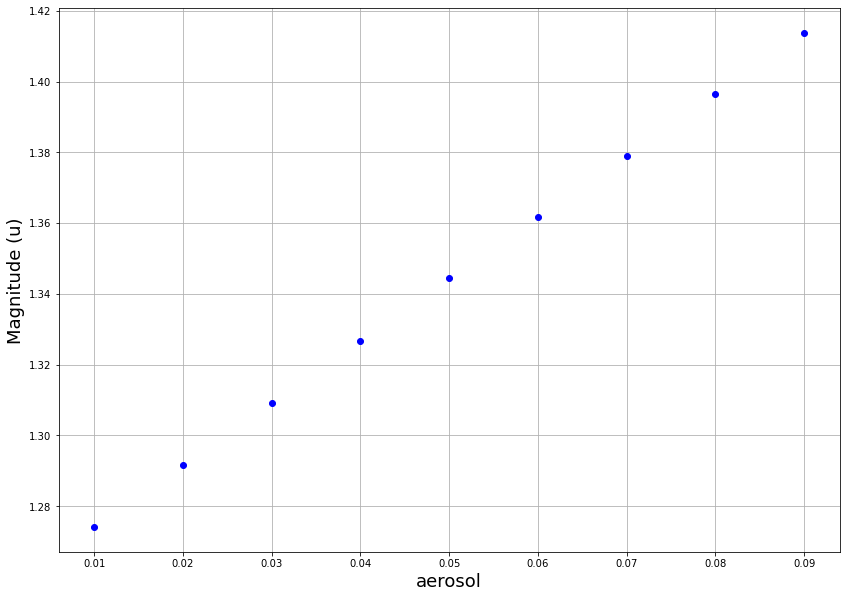

In [92]:
band = 'u'
plt.figure(figsize=(14,10))
plt.plot(atm_vals,mag_dict[test_type][test_spec][band],ls='',marker='o',color='b',label=band)
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('Magnitude ({0})'.format(band),fontsize=18)
#plt.legend(loc="best")

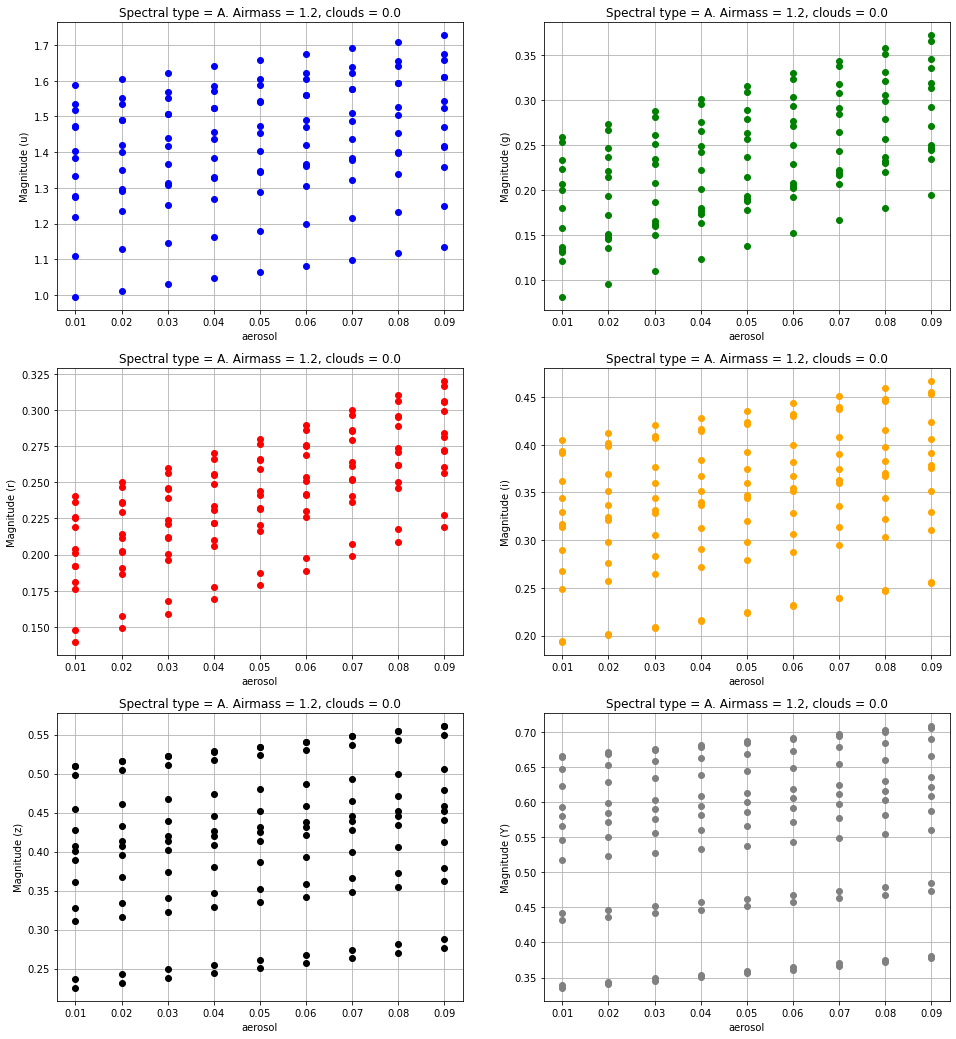

In [93]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters):
            band = filters[i]
            for si in mag_dict[test_type]:
                axs[row,col].plot(atm_vals,mag_dict[test_type][si][band],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel('Magnitude ({0})'.format(band))
            axs[row,col].set_title('Spectral type = {0}. Airmass = {1}, clouds = {2}'.format(test_type,am0,cloud0))
            i += 1
            

Now we do the same for the colours: 

Text(0, 0.5, 'u-g')

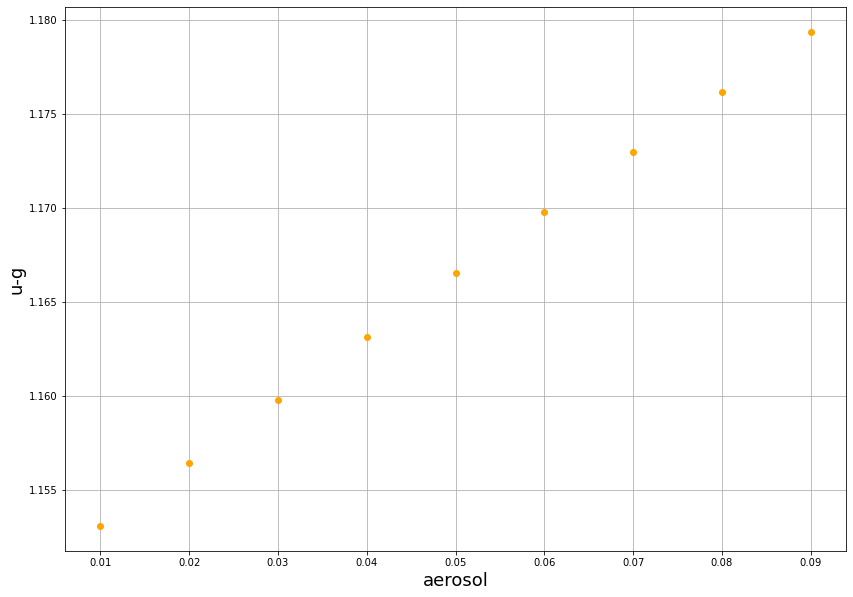

In [94]:
plt.figure(figsize=(14,10))
col = 'u-g'
color_ = colour_dict[test_type][test_spec][col]
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('{0}'.format(col),fontsize=18)

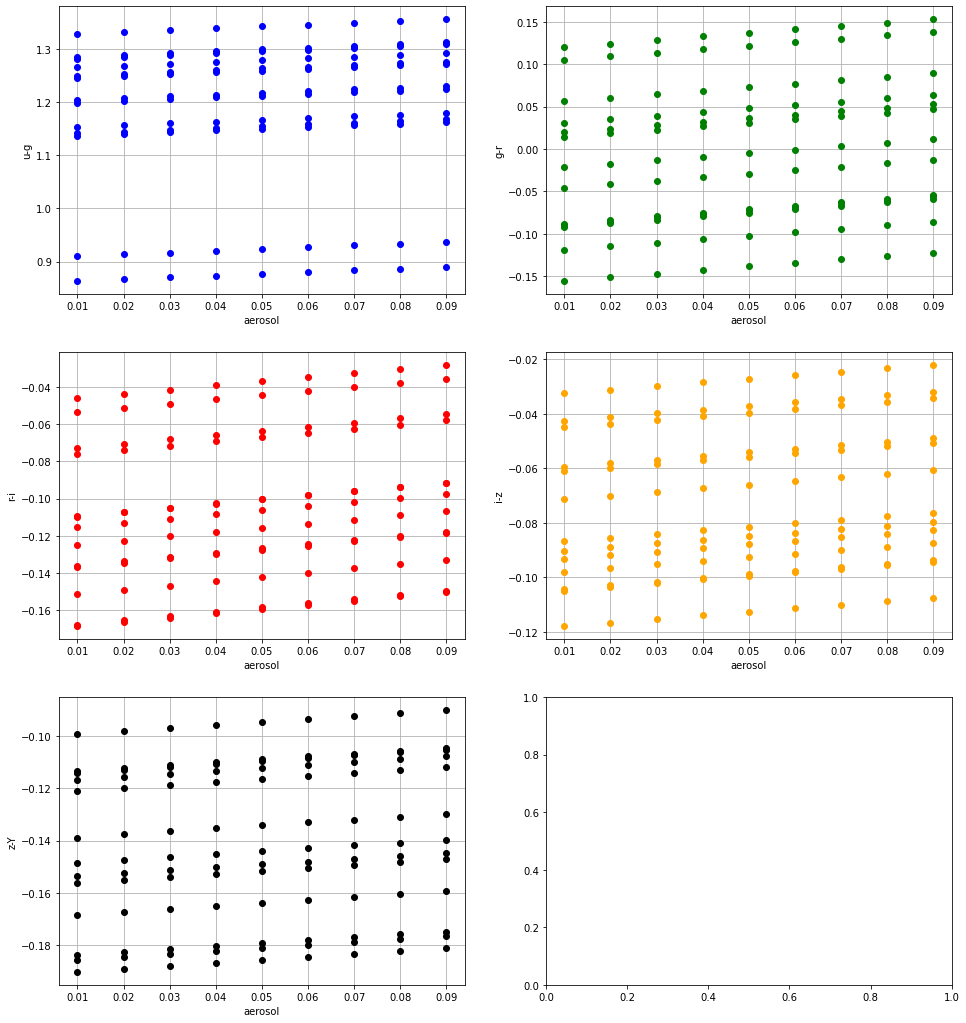

In [95]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in colour_dict[test_type]:
                axs[row,col].plot(atm_vals,colour_dict[test_type][si][c.lower()],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(c)
            #axs[row,col].legend()
            i += 1

Doing the same but with respect to the reference atmosphere, that is, $\Delta c = c - c_{ref}$: 

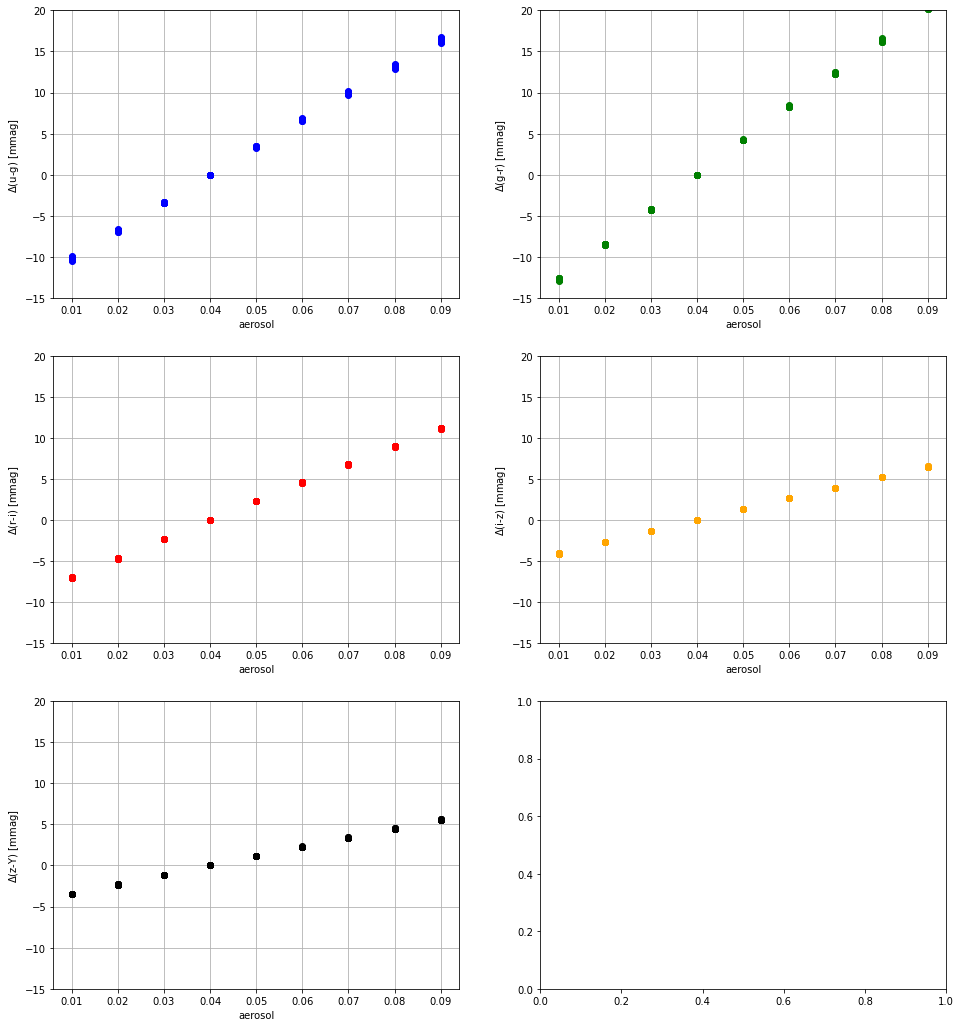

In [139]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in range(len(colour_dict[test_type])):
                #if si not in [15,16,17,18]:
                axs[row,col].plot(atm_vals,(colour_dict[test_type][si][c.lower()]-colour_dict_ref[test_type][si][c.lower()])*1000.,ls='',marker='o',color=filter_colors[i])
            
            axs[row,col].grid()
            axs[row,col].set_ylim(-15,20)
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+c+') [mmag]')
            #axs[row,col].legend()
            i += 1

# Evaluate the colour - colour plot as a function of the atmospheric parameter values 

Let's check first with the example spectrum: 

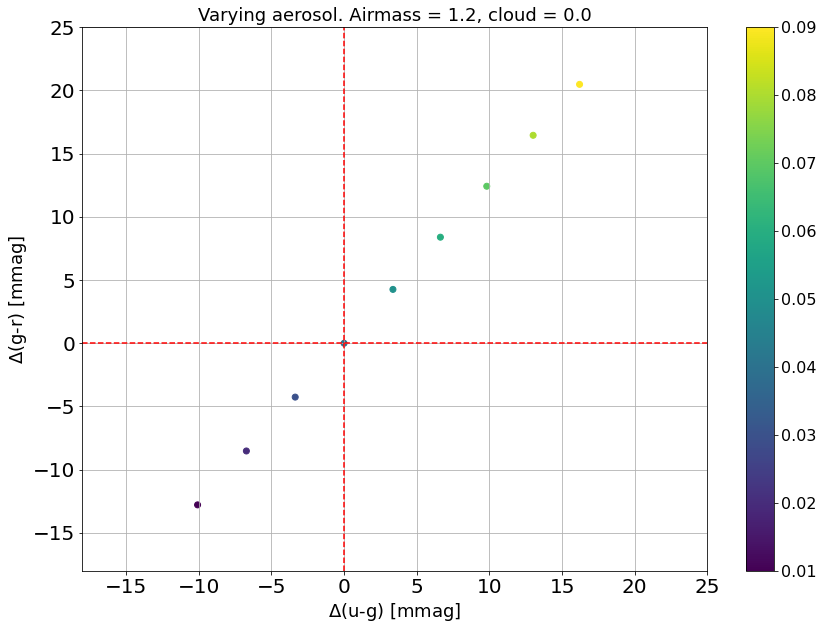

In [159]:
colorx = 'u-g'
colory = 'g-r'
plt.figure(figsize=(14,10))
delta1 = (colour_dict[test_type][test_spec][colorx.lower()]-colour_dict_ref[test_type][test_spec][colorx.lower()])*1000.
delta2 = (colour_dict[test_type][test_spec][colory.lower()]-colour_dict_ref[test_type][test_spec][colory.lower()])*1000.
plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(-18,25)
plt.ylim(-18,25)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Varying {0}. Airmass = {1}, cloud = {2}'.format(variable_param,am0,cloud0),fontsize=18)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_colour_colour_plot_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

Select Delta_color ranges 

In [155]:
rangex = (-18,25)
rangey = (-18,25)

Now we evaluate the colour - colour plot for all spectra of the example spectral type: 

In [156]:
save_plot = True

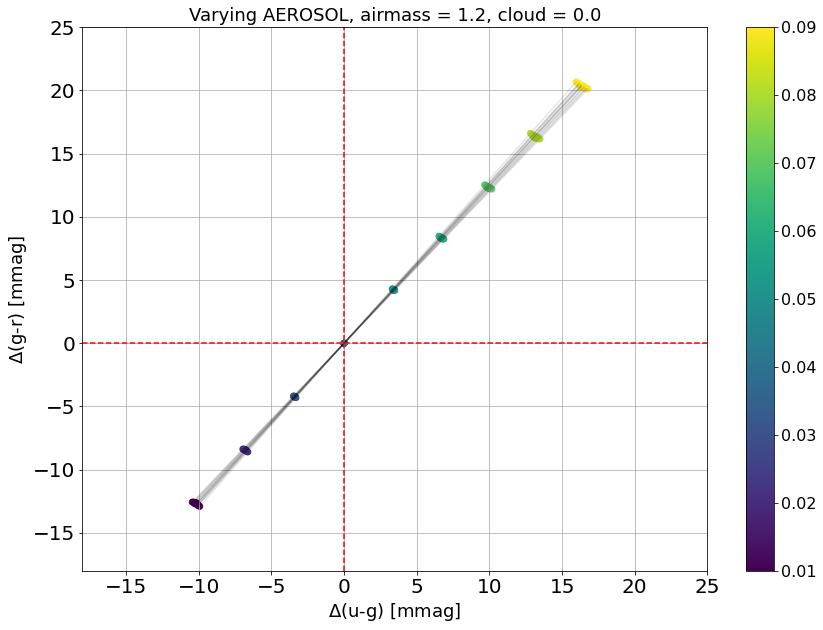

In [157]:
colorx = 'u-g'
colory = 'g-r'
plt.figure(figsize=(14,10))
for si in colour_dict[test_type]:
    delta1 = (colour_dict[test_type][si][colorx.lower()]-colour_dict_ref[test_type][si][colorx.lower()])*1000.
    delta2 = (colour_dict[test_type][si][colory.lower()]-colour_dict_ref[test_type][si][colory.lower()])*1000.
    plt.plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
    plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(rangex)
plt.ylim(rangey)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
#plt.title('Spectral type: {0}. Number of spectra = {1}'.format(test_type,len(colour_dict[test_type].keys())),fontsize=16)
if save_plot:
    if variable_param=='airmass' or variable_param=='cloud':
        plt.title('Varying {0}'.format(variable_param.upper()),fontsize=18)
    else:
        plt.title('Varying {0}, airmass = {1}, cloud = {2}'.format(variable_param.upper(),am0,cloud0),fontsize=18)
    if variable_param=='airmass' or variable_param=='cloud':
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying{1}.png'.format(test_type,variable_param)))
    else:
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying_{1}_airmass_{2}_cloud_{3}.png'.format(test_type,variable_param,am0,cloud0)))


Let's evaluate the same colour - colour plot for the different spectral types: 

O
B
A
F
G
K
M


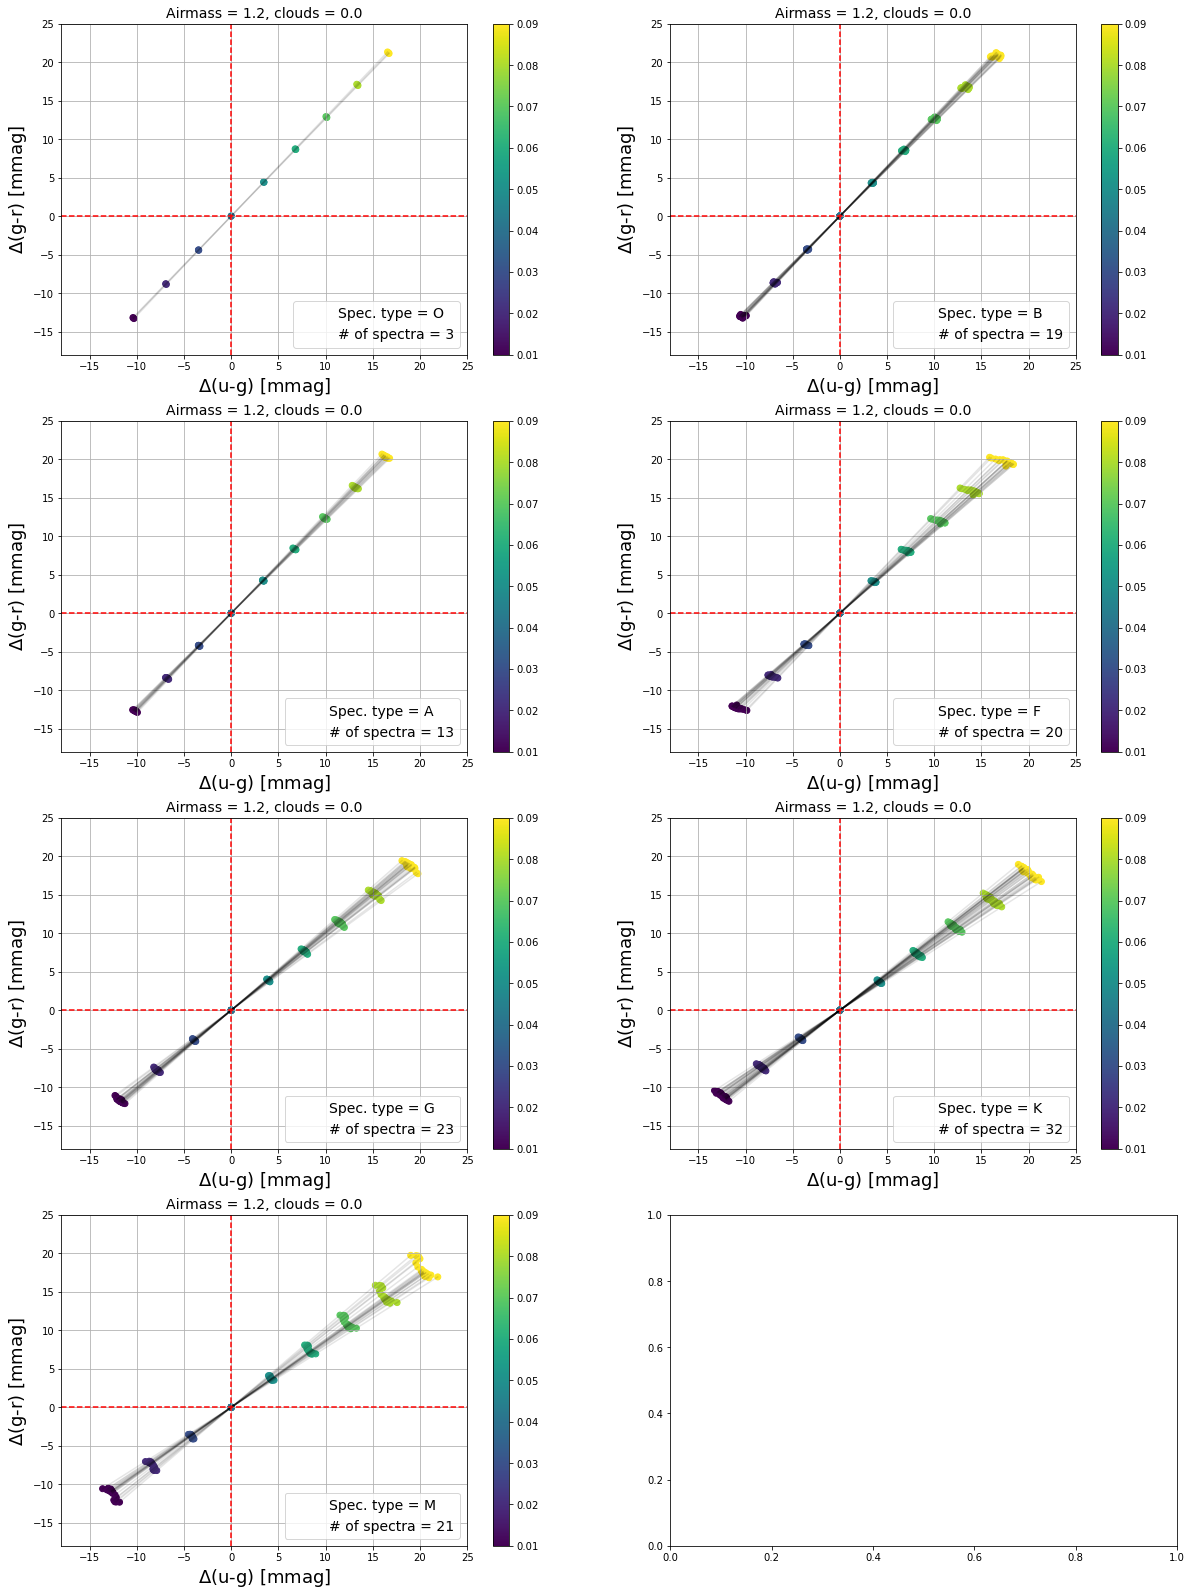

In [158]:
colorx = 'u-g'
colory = 'g-r'

fig_rows = 4
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,28))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(spectral_types):
            spec_type = spectral_types[i]
            print(spec_type)
            
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(spec_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[spec_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1


Now we evaluate the different colour - colour plots for the example spectral type: 

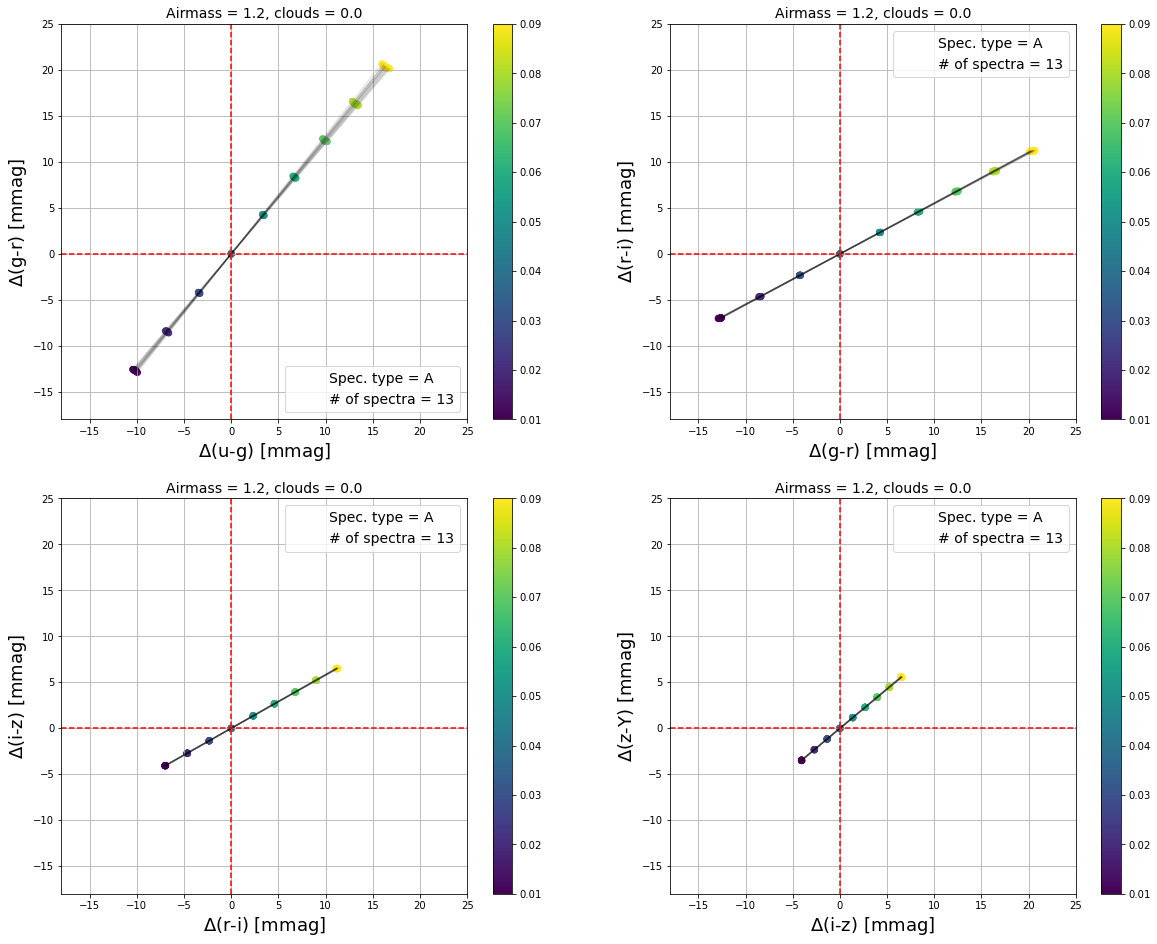

In [160]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for si in colour_dict[test_type]:
                delta1 = (colour_dict[test_type][si][cx.lower()]-colour_dict_ref[test_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[test_type][si][cy.lower()]-colour_dict_ref[test_type][si][cy.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            #axs[row,col].set_xlim(-0.012,0.021)
            #axs[row,col].set_ylim(-0.065,0.126)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(test_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[test_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1

We also evaluate the dependency of the colours with the atmospheric parameters for each spectral type: 

In [161]:
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

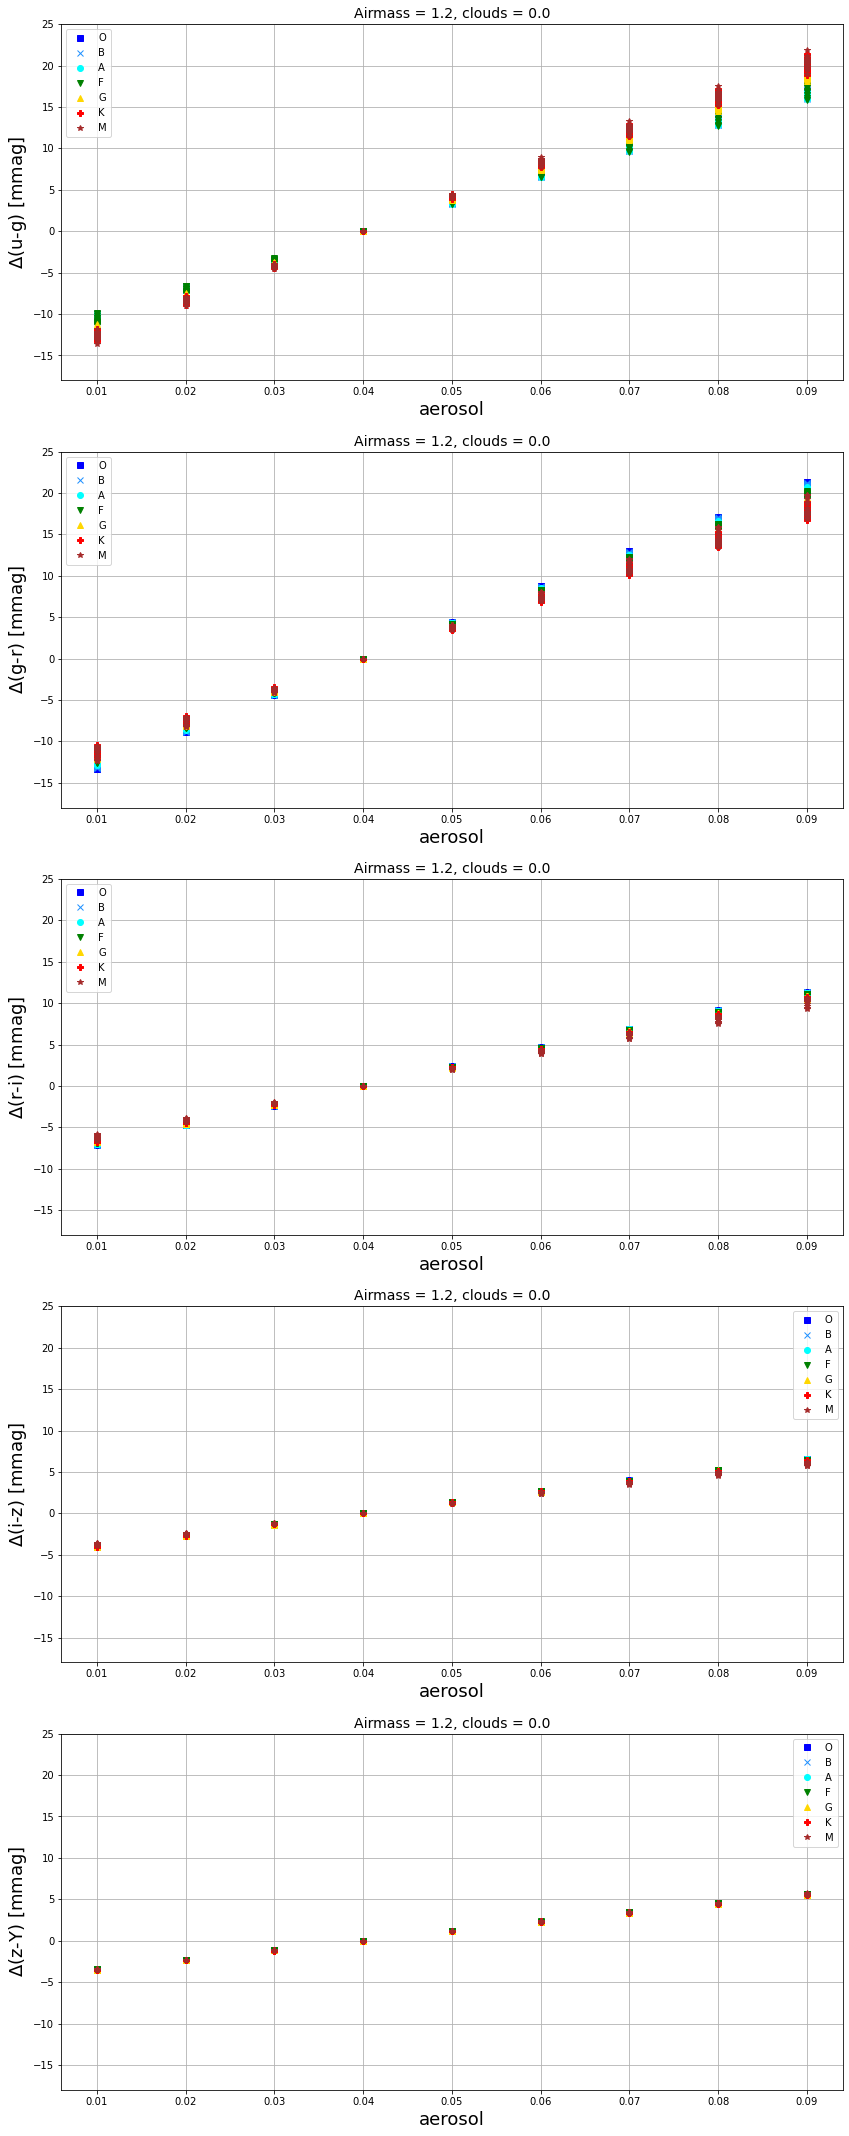

In [162]:
fig_rows = len(filters)-1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(14,38))
for row in range(fig_rows):
    c = '{0}-{1}'.format(filters[row],filters[row+1])
    for spec_type in spectral_types:
        for si in mag_dict[spec_type]:
            delta_c_ = (colour_dict[spec_type][si][c.lower()]-colour_dict_ref[spec_type][si][c.lower()])*1000.
            axs[row].plot(atm_vals,delta_c_,ls='',marker=type_markers[spec_type],color=type_colors[spec_type])
        axs[row].plot([],[],ls='',marker=type_markers[spec_type],color=type_colors[spec_type],label = spec_type)
    axs[row].set_ylim(rangey)
    axs[row].grid()
    axs[row].set_xlabel(variable_param,fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+c+') [mmag]',fontsize=18)
    axs[row].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
    axs[row].legend()
plt.savefig(os.path.join(outdir_plots,'delta_colours_vs_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))
    

Let's have a look now at the colour-colour plots for all spectral types together 

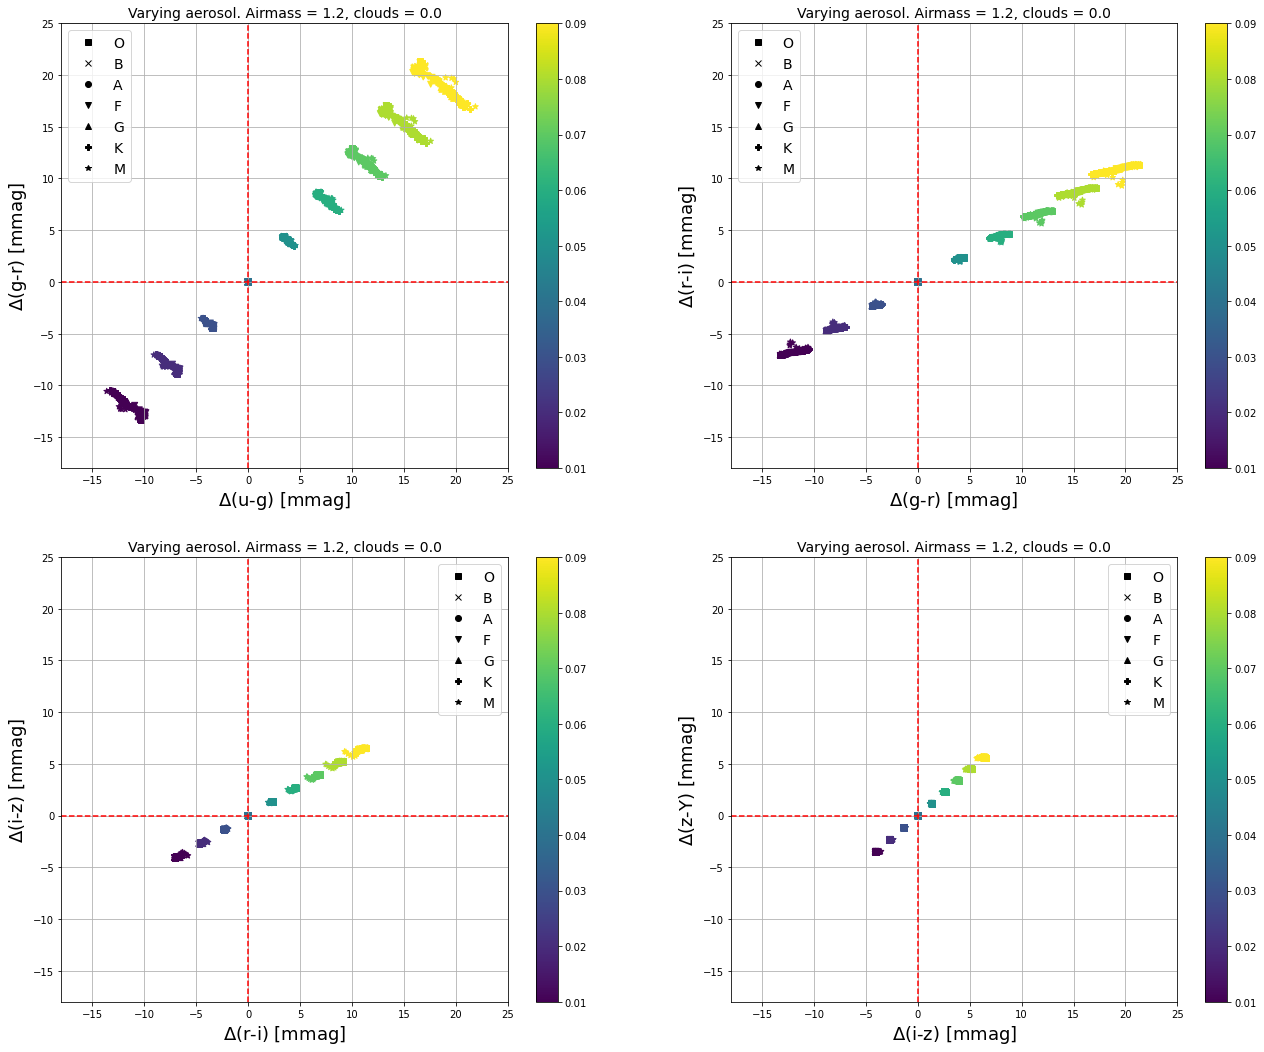

In [163]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    if sed_==0:
                        im = axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    else:
                        axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    #axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c='k',ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

An alternative way of plotting this: 

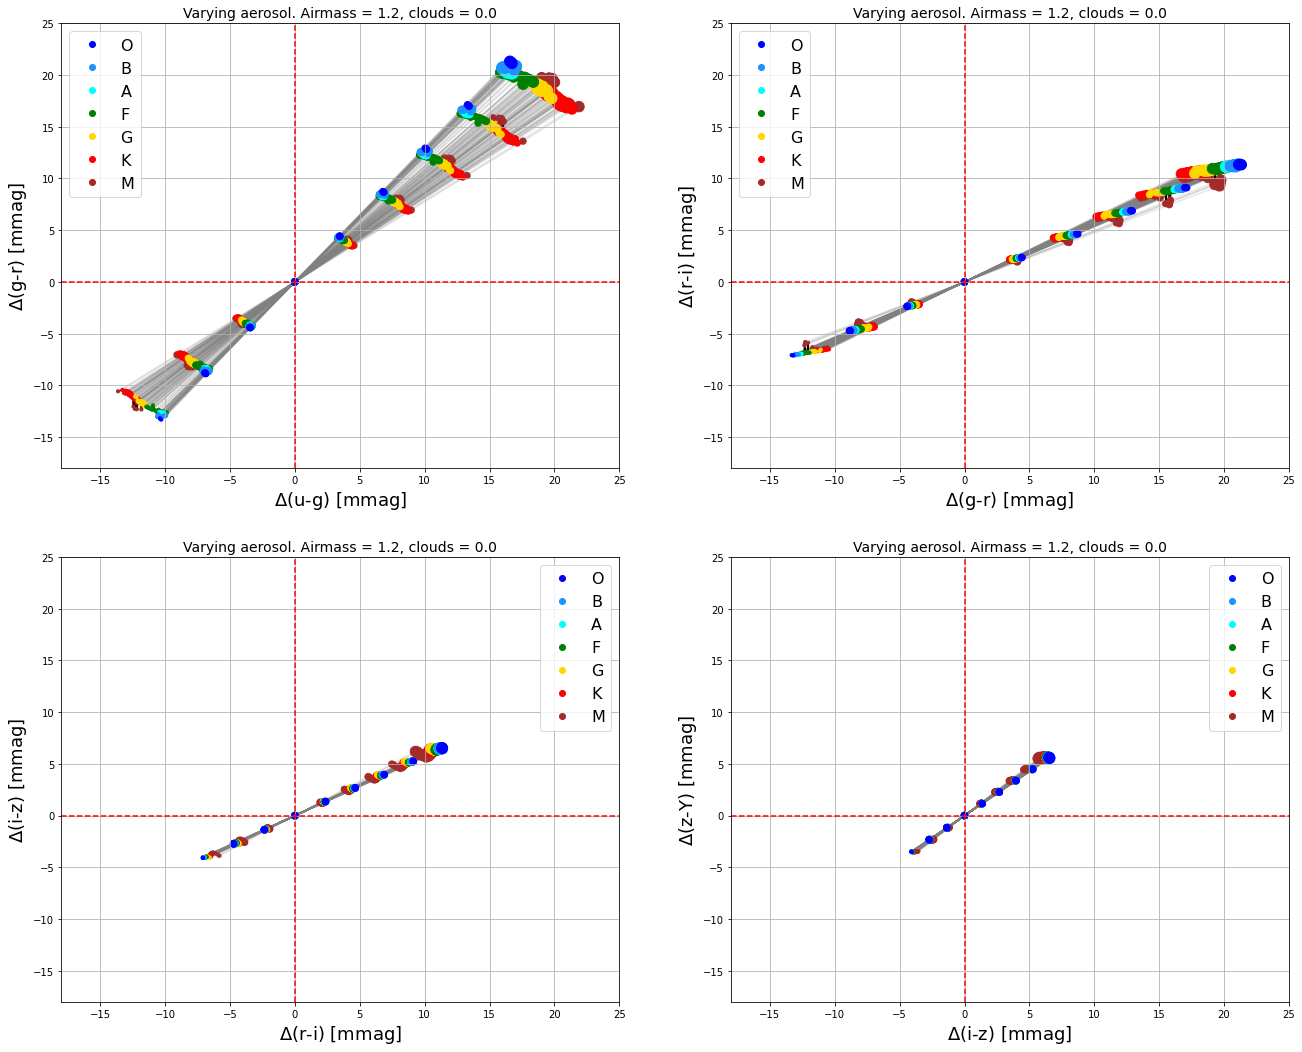

In [210]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            i += 1
            
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2.png'.format(variable_param,am0,cloud0)))

Plot and save them individually: 

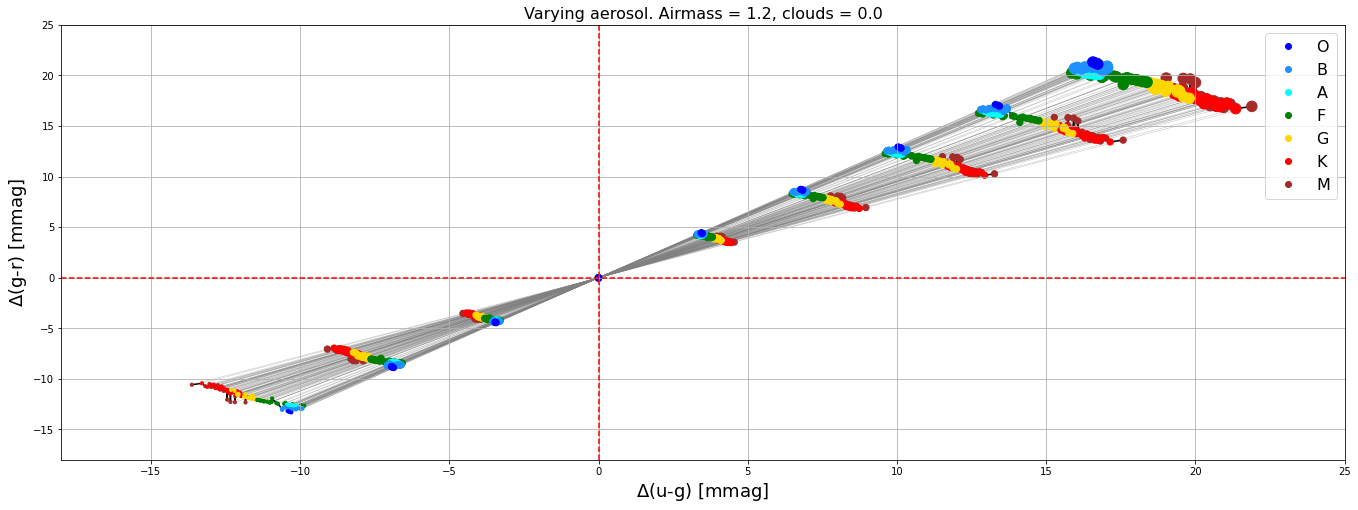

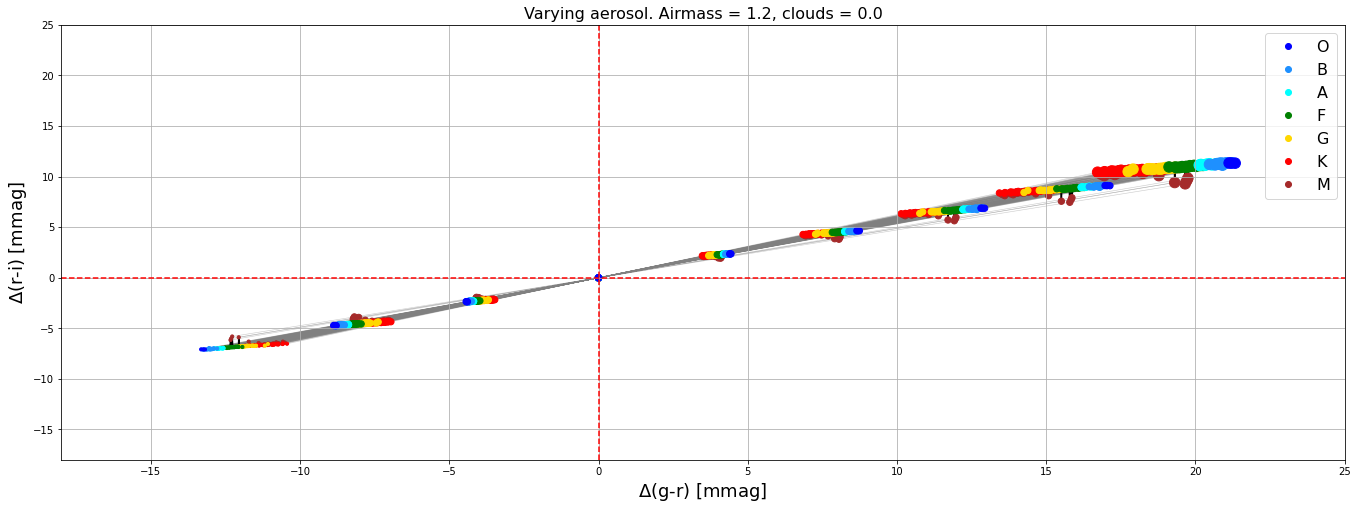

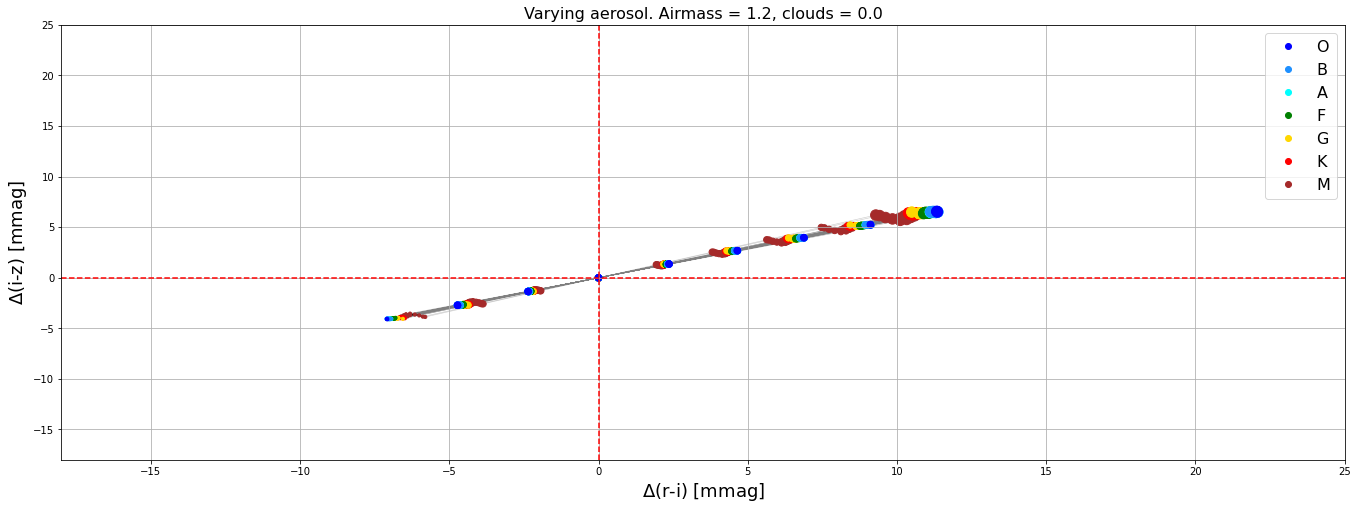

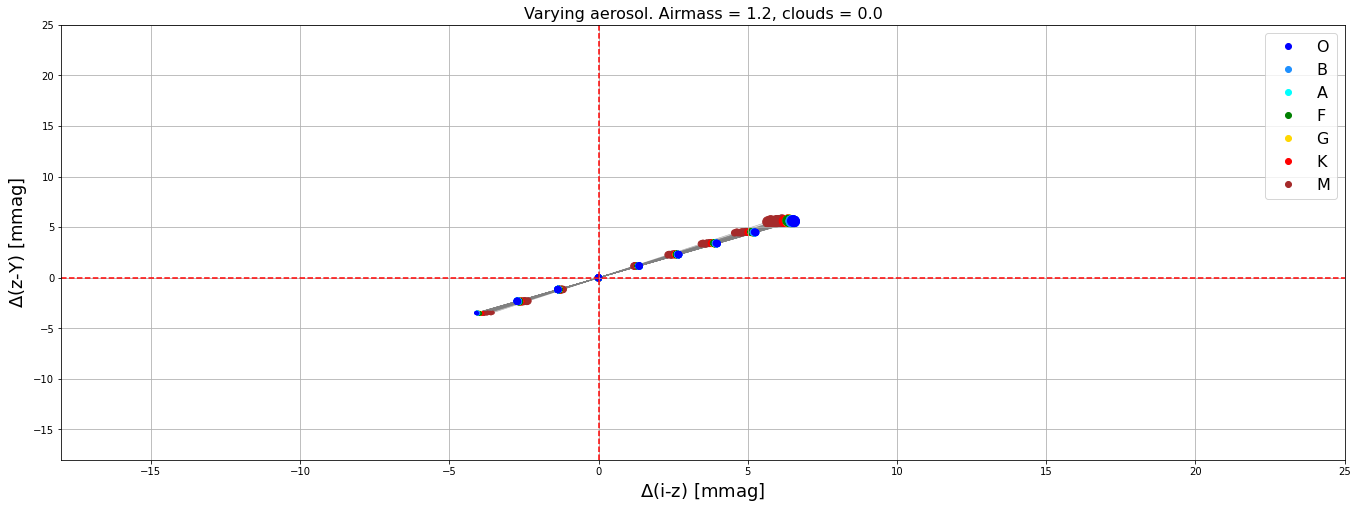

In [209]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(23,8))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex)
        axs.set_ylim(rangey)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=16)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0,cx,cy)))

Now we look at the same information but restricted to the most extreme atmospheric parameter values: 

u
g
r
i
z
Y
photlam


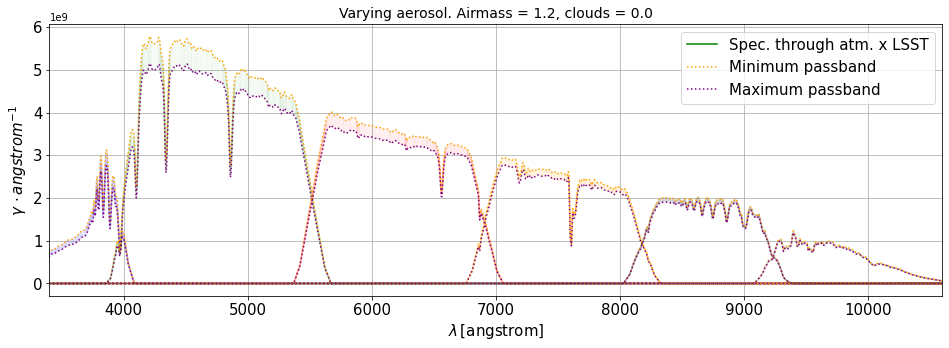

In [169]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
    ax.plot(obstotal_dict[filter][min_ind_].binwave,obstotal_dict[filter][min_ind_].binflux*Seff*exptime,ls=':',color='orange')
    ax.plot(obstotal_dict[filter][max_ind_].binwave,obstotal_dict[filter][max_ind_].binflux*Seff*exptime,ls=':',color='purple')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.plot([],[],ls=':',color='orange',label='Minimum passband')
plt.plot([],[],ls=':',color='purple',label='Maximum passband')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_min_max_total_passband_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))
print(spec.fluxunits)

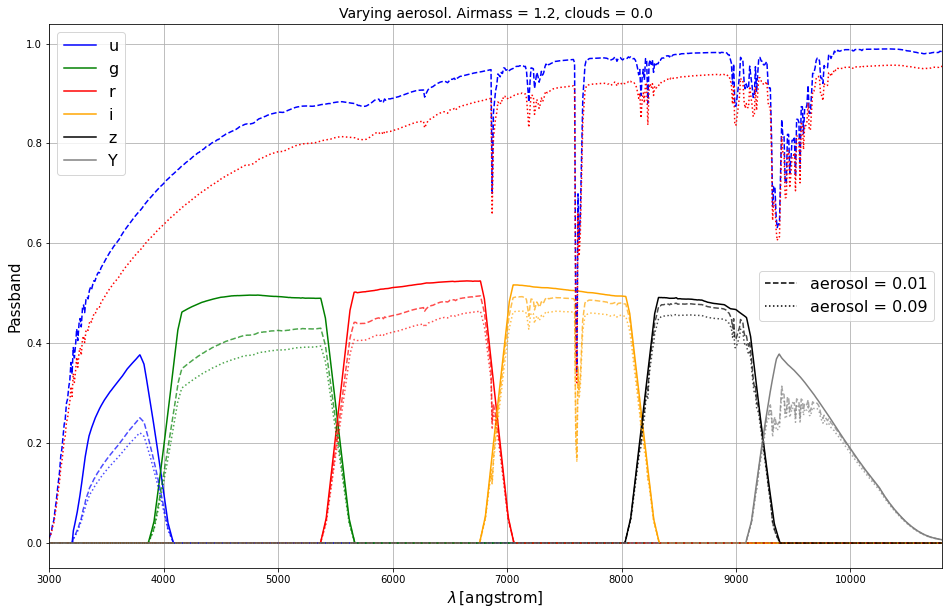

In [170]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
legend_lines1 = []
for index,bp in enumerate(lsst_bp):
    line_, = ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])
    legend_lines1.append(line_)

ax.plot(atm_transp[min_ind_].wave,atm_transp[min_ind_].throughput,ls='--',alpha=1.0,color='b')
ax.plot(atm_transp[max_ind_].wave,atm_transp[max_ind_].throughput,ls=':',alpha=1.0,color='r')

for index,bpname in enumerate(filters):
    ax.plot(total_passband[bpname][min_ind_].wave,total_passband[bpname][min_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)
    ax.plot(total_passband[bpname][max_ind_].wave,total_passband[bpname][max_ind_].throughput,ls=':',color=filter_colors[index],alpha=0.7)        
line1, = plt.plot([],[],ls='--',color='k',label='{0} = {1}'.format(variable_param,min_val_))
line2, = plt.plot([],[],ls=':',color='k',label='{0} = {1}'.format(variable_param,max_val_))
legend_lines2 = [line1,line2]
plt.xlim(3000.,10800.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Passband',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
legend1 = plt.legend(handles=legend_lines1,fontsize=16,loc="upper left")
plt.gca().add_artist(legend1)
plt.legend(handles=legend_lines2,fontsize=16,loc="center right")
plt.savefig(os.path.join(outdir_plots,'total_passbands_min_max_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

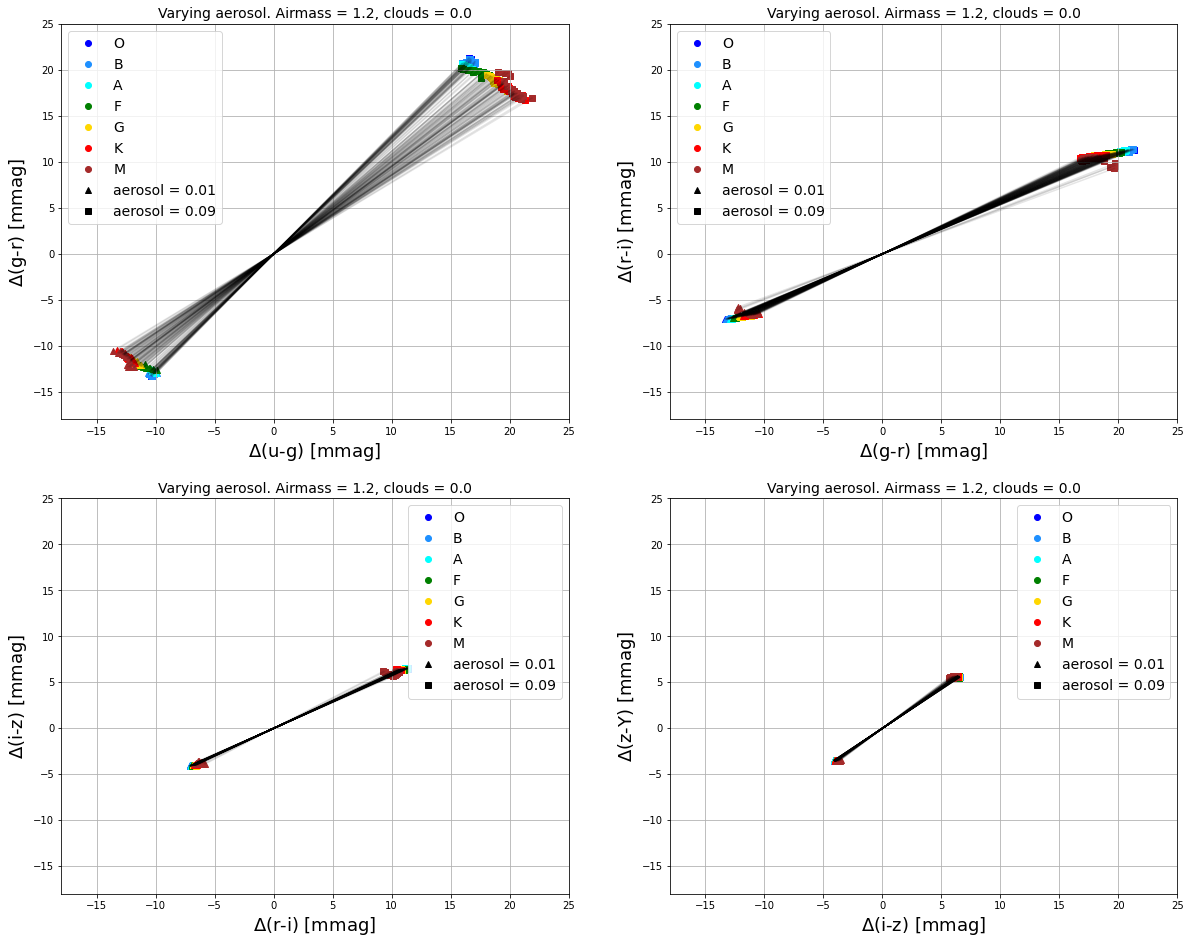

In [171]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_min = (colour_dict[spec_type][si][cx.lower()][min_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_min = (colour_dict[spec_type][si][cy.lower()][min_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_min,delta2_min,c=type_colors[spec_type],marker='^')
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker='s')
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            axs[row,col].plot([],[],ls='',marker='^',color='k',label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
            axs[row,col].plot([],[],ls='',marker='s',color='k',label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
            #axs[row,col].axhline(y=0.,ls='--',color='r')
            #axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
    
            i += 1

plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_min_max_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

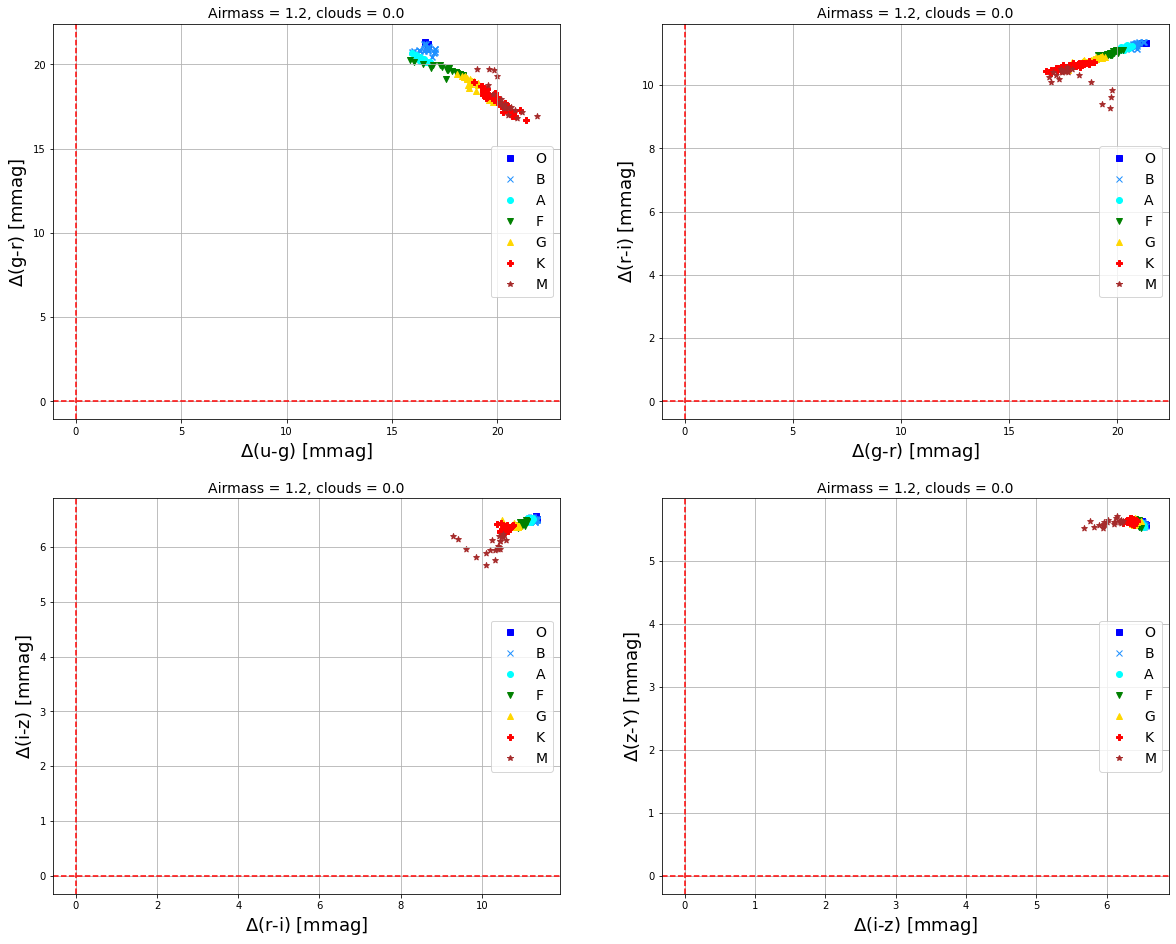

In [172]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

We exclude the M type spectra for more clarity: 

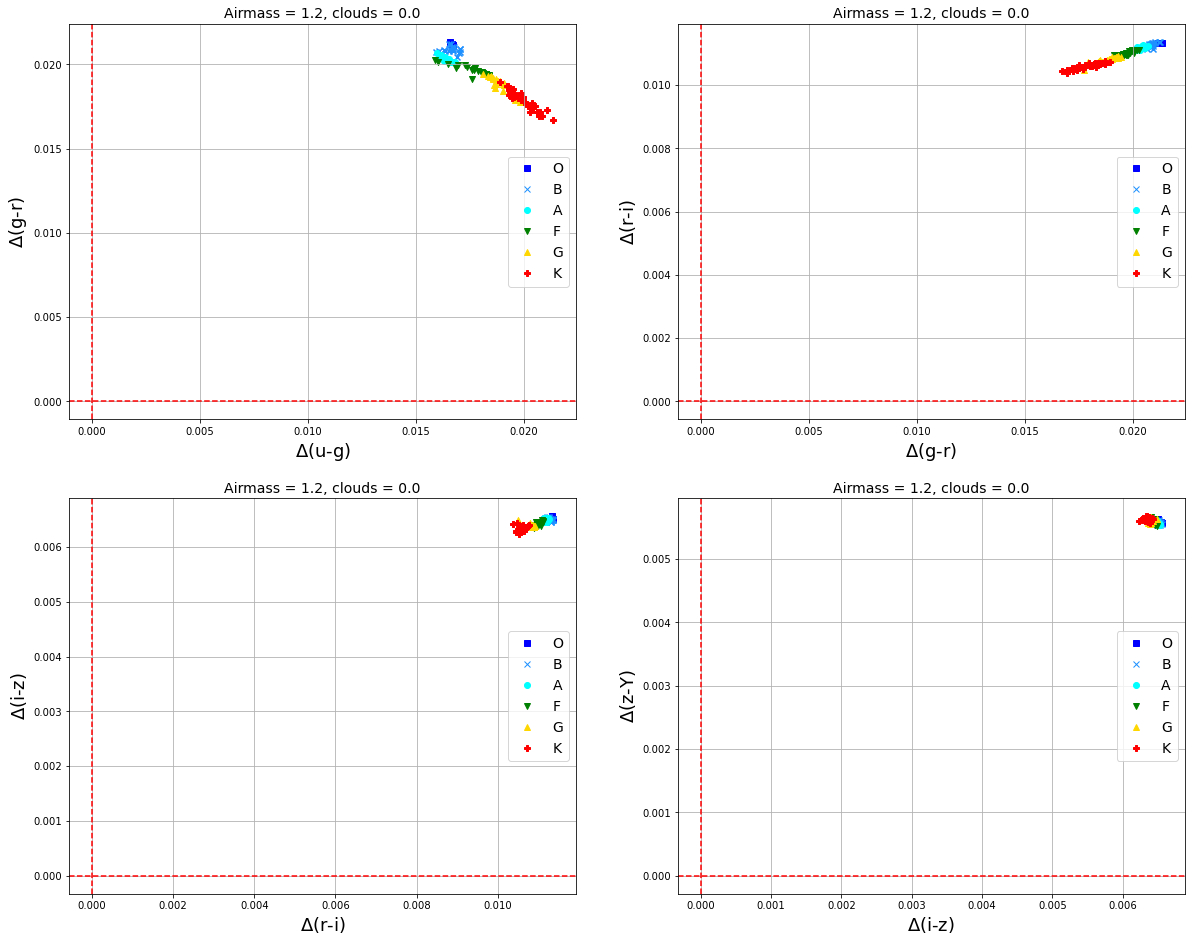

In [173]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types[:-1]:
                for si in colour_dict[spec_type]:
                    delta1_max = colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()]
                    delta2_max = colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()]
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+')',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+')',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

# Make 3D colour plot 

To see an interactive version of the following plot, see notebook "03_spectrum_ThroughAtmLSST_3Dcolor_plot.ipynb" 

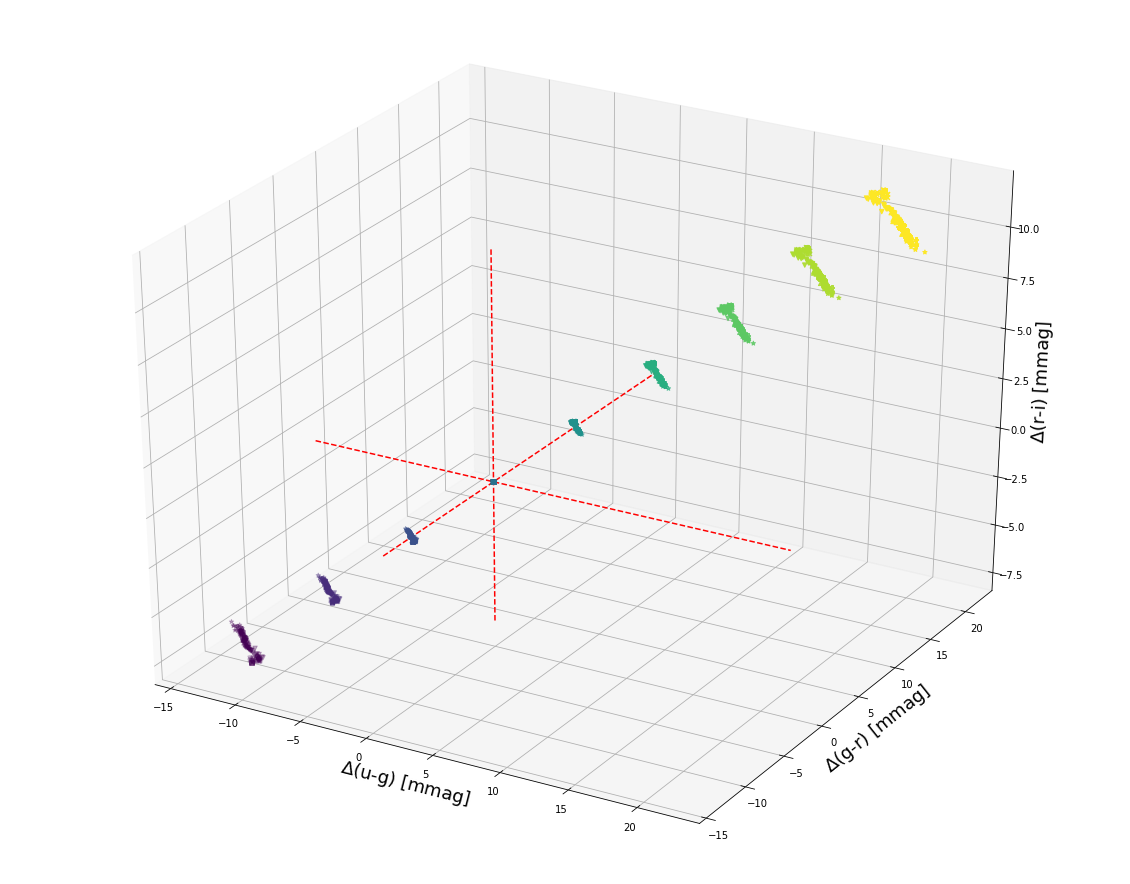

In [175]:
colorx = 'u-g'
colory = 'g-r'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


# Calculate colour evolution for SNe Ia spectra 

We use the SNe Ia spectra from https://github.com/rhiannonlynne/photometry_sample/tree/main/sn 

In [176]:
sne_path = 'data/SNIa_spectra/'
sn1_data = np.loadtxt(os.path.join(sne_path,'sn1a_10.0.dat'))
sn2_data = np.loadtxt(os.path.join(sne_path,'sn1a_15.0.dat'))
sn3_data = np.loadtxt(os.path.join(sne_path,'sn1a_20.0.dat'))

The wavelengths are in nm and the fluxes in erg/s/cm2/nm, so we need to change the units to angstrom and photlam = #photons/s/cm2/angstrom (pysynphot assumes that the input fluxes are in photlam). For this, we need to remember that the conversion between flam (erg/s/cm2/angstrom) and photlam is given by 

$$ photlam = \frac{\lambda}{h \cdot c} flam $$

In [177]:
sn1wave = sn1_data[:,0]*10.
sn2wave = sn2_data[:,0]*10.
sn3wave = sn3_data[:,0]*10.

sn1flux = sn1_data[:,1]*sn1wave/(h_planck*c_light)
sn2flux = sn2_data[:,1]*sn2wave/(h_planck*c_light)
sn3flux = sn3_data[:,1]*sn3wave/(h_planck*c_light)

In [178]:
sn1 = S.ArraySpectrum(sn1wave,sn1flux,name='sn1a_10.0')
sn2 = S.ArraySpectrum(sn2wave,sn2flux,name='sn1a_15.0')
sn3 = S.ArraySpectrum(sn3wave,sn3flux,name='sn1a_20.0')

In [179]:
sn1.waveunits, sn1.fluxunits

(<pysynphot.units.Angstrom at 0x7fce1faad430>,
 <pysynphot.units.Photlam at 0x7fce1faad460>)

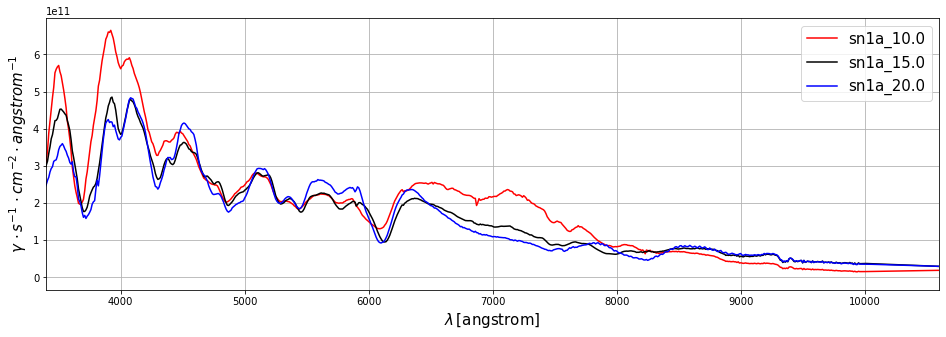

In [180]:
fig=plt.figure(figsize=(16,5))
plt.plot(sn1.wave,sn1.flux,color='r',label=sn1.name)
plt.plot(sn2.wave,sn2.flux,color='k',label=sn2.name)
plt.plot(sn3.wave,sn3.flux,color='b',label=sn3.name)
plt.xlim(WLMIN,WLMAX)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot s^{-1} \, \cdot cm^{-2} \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=15)

Now we pass the SNIa spectra through the total passbands, as with the calibration spectra 

In [181]:
sn_list = [sn1,sn2,sn3]

In [182]:
# SNe Ia through atm x throughput 
sn_obs_dict = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    sn_obs_dict[si] = filter_dict_ 


((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [183]:
print(len(sn_obs_dict.keys()))
print(len(sn_obs_dict[0].keys()))
print(len(sn_obs_dict[0]['u']))

3
6
9


In [184]:
# SNe Ia only through throughput (as if telescope was in space) 
sn_obs_dict_t = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name] = obs_spec_t
    sn_obs_dict_t[si] = filter_dict_ 
    

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in

In [185]:
print(len(sn_obs_dict_t.keys()))
print(len(sn_obs_dict_t[0].keys()))
print(sn_obs_dict_t[0]['u'].flux)

3
6
[ 0.  0.  0. ... nan nan nan]


Text(0.5, 1.0, 'Varying aerosol. Airmass = 1.2, clouds = 0.0')

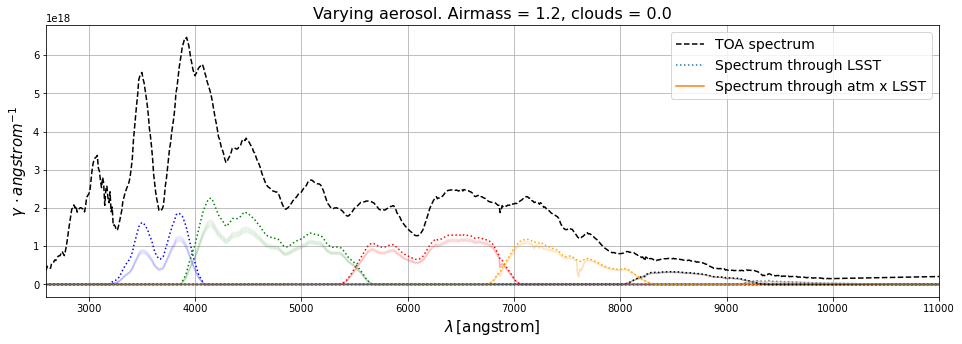

In [186]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We zoom in to see the effect of the different atmospheric transparencies 

Text(0.5, 1.0, 'Varying aerosol. Airmass = 1.2, clouds = 0.0')

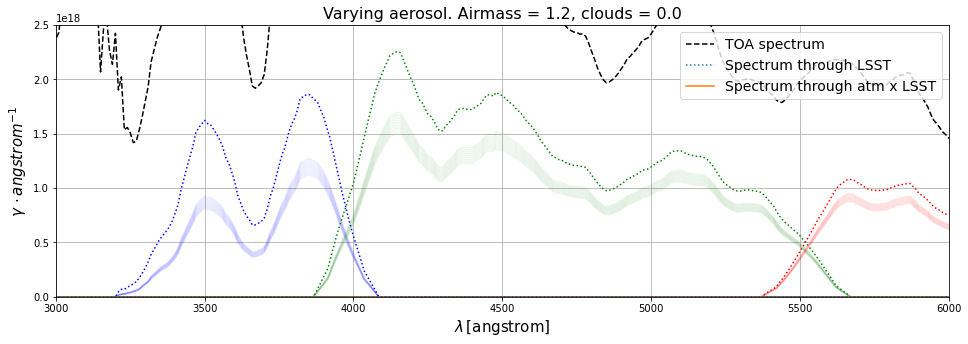

In [188]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.07)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(3000.,6000.)
plt.ylim(0,2.5e18)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We can now calculate the magnitudes and colours 

In [189]:
# Magnitudes of spectra passing through atm x throughput 
sn_mag_dict = {}
sn_mag_dict_ref = {}
for si,obs_spec_ in enumerate(sn_list):
    mag_dict_ = {}
    mag_dict_ref_ = {}
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        for i in range(n_sim):
            #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
            mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
            
        #mag_dict[sed_] = mag_dict_
        
        mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    sn_mag_dict[si] = mag_dict_
    sn_mag_dict_ref[si] = mag_dict_ref_

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.531733257486835
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.51408224917236
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.496431717192994
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. Th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.745443005325868
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.73758458830283
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.729599120780165
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.72161627

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.237856465325812
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.770552072467453
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.756209121663662
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.7418682

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.004520943360568
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.037099078308664
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.566669301239102
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.5615499

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.70055055156974
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.690587173946806
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.680624470304036
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.67057078

-19.534198471339344
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.52864250568902
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.52308677056317
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.5502540850125


In [190]:
print(len(sn_mag_dict.keys()))
print(len(sn_mag_dict[0].keys()))
print(len(sn_mag_dict[0]['u']))

3
6
9


In [191]:
sn_colour_dict = {}
for sn in sn_mag_dict.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict[sn] = c_dict


In [192]:
print(len(sn_mag_dict.keys()))
print(len(sn_colour_dict.keys()))
print(len(sn_colour_dict[0].keys()))
print(len(sn_colour_dict[0]['u-g']))

3
3
5
9


In [193]:
sn_colour_dict_ref = {}
for sn in sn_mag_dict_ref.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict_ref[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict_ref[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict_ref[sn] = c_dict
    

In [194]:
print(len(sn_mag_dict_ref.keys()))
print(len(sn_colour_dict_ref.keys()))
print(len(sn_colour_dict_ref[0].keys()))
print(sn_colour_dict_ref[0]['u-g'])

3
3
5
0.34546386375220806


In [195]:
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),sn_colour_dict)
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),sn_colour_dict_ref)

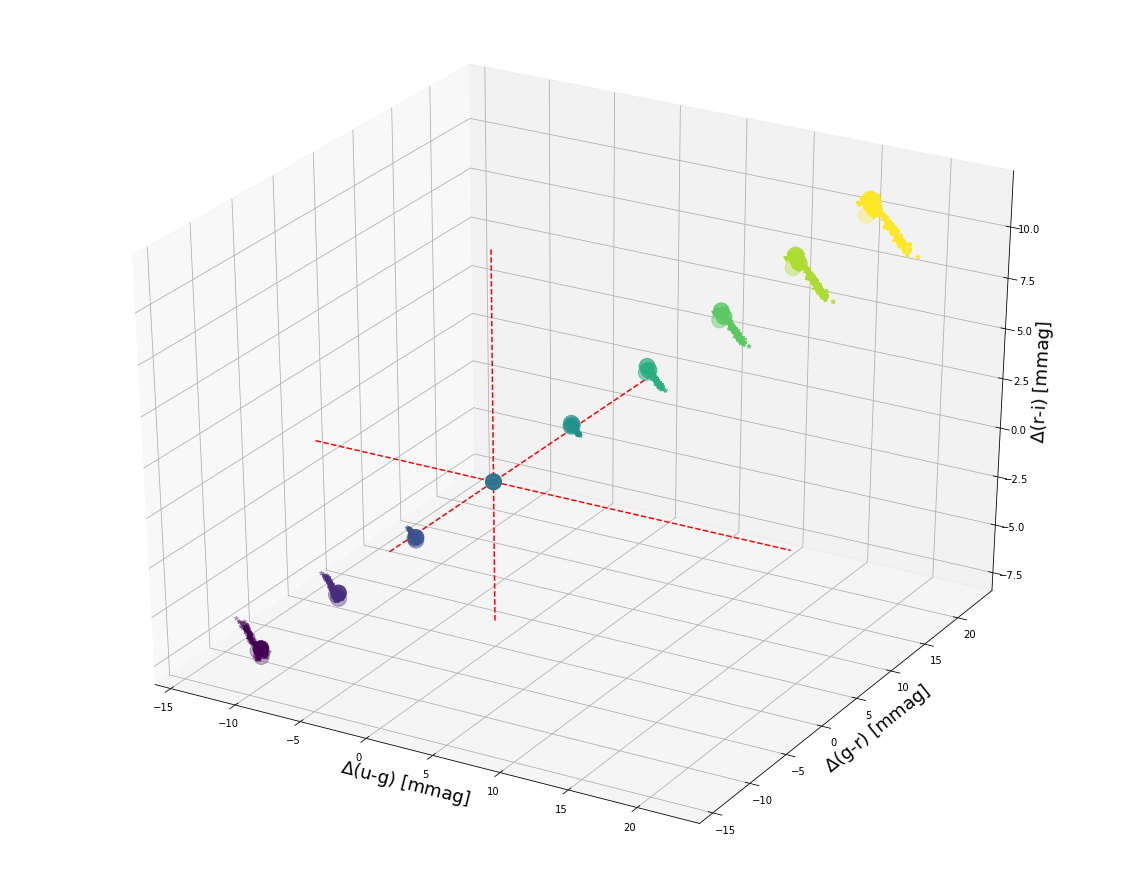

In [196]:
colorx = 'u-g'
colory = 'g-r'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))
        
for sn in sn_colour_dict.keys():
    delta1_sn = (sn_colour_dict[sn][colorx.lower()]-sn_colour_dict_ref[sn][colorx.lower()])*1000.
    delta2_sn = (sn_colour_dict[sn][colory.lower()]-sn_colour_dict_ref[sn][colory.lower()])*1000.
    delta3_sn = (sn_colour_dict[sn][colorz.lower()]-sn_colour_dict_ref[sn][colorz.lower()])*1000.
    
    ax.scatter(delta1_sn,delta2_sn,delta3_sn,c=atm_vals,marker='o',s=250.0)

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


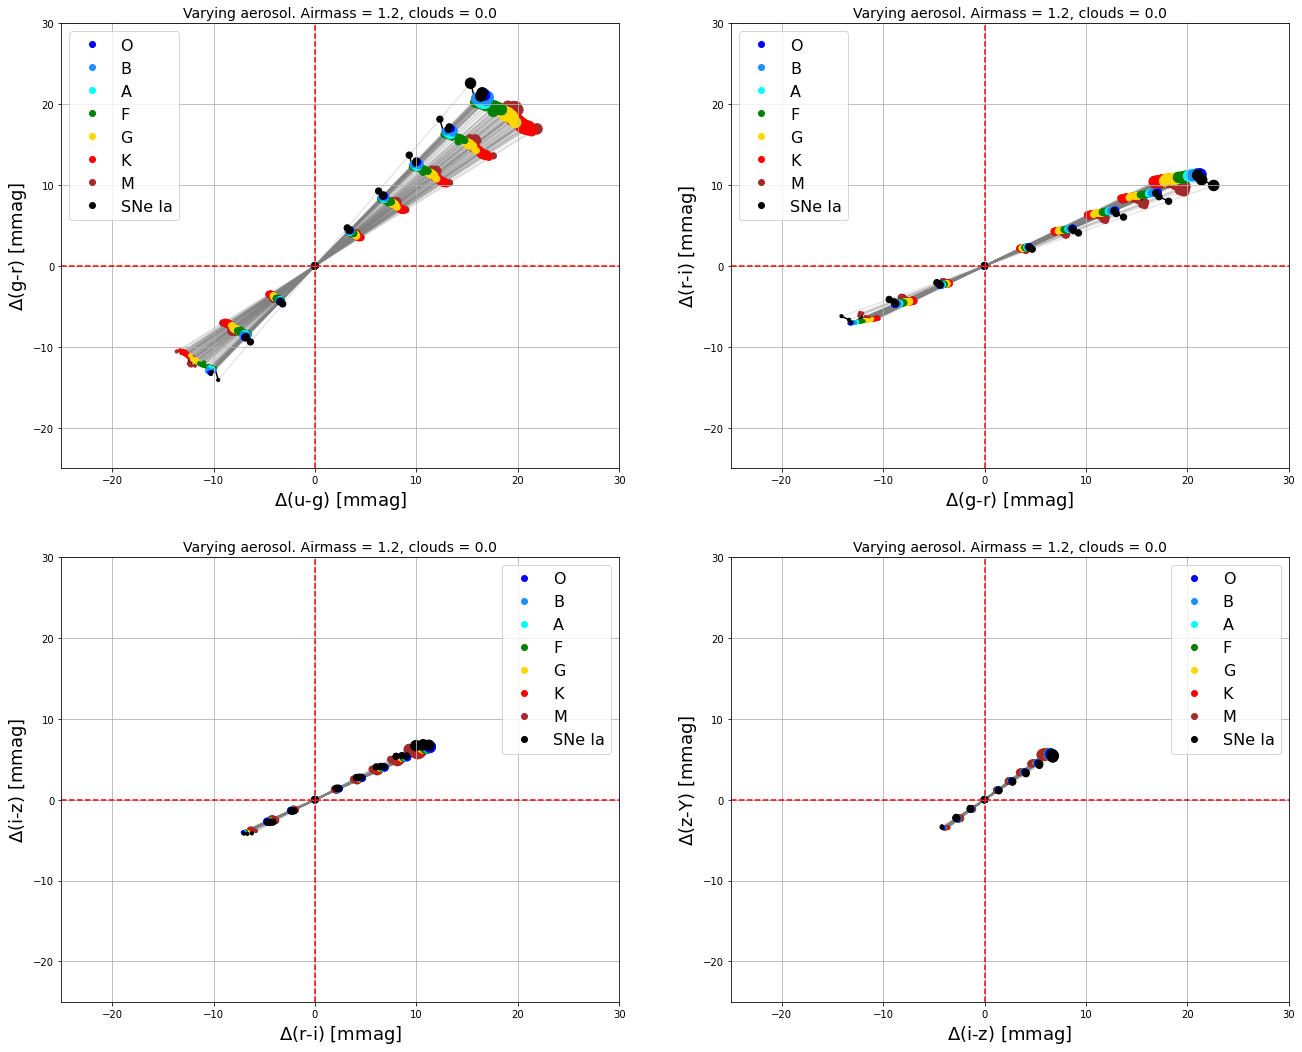

In [208]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
                
            for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs[row,col].scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs[row,col].plot(delta1_sn,delta2_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            axs[row,col].plot([],[],c='k',ls='',marker='o',label='SNe Ia')
            
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(-25,30)
            axs[row,col].set_ylim(-25,30)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2_sn.png'.format(variable_param,am0,cloud0)))

In [200]:
rangex2 = (-25,30)
rangey2 = (-25,30)

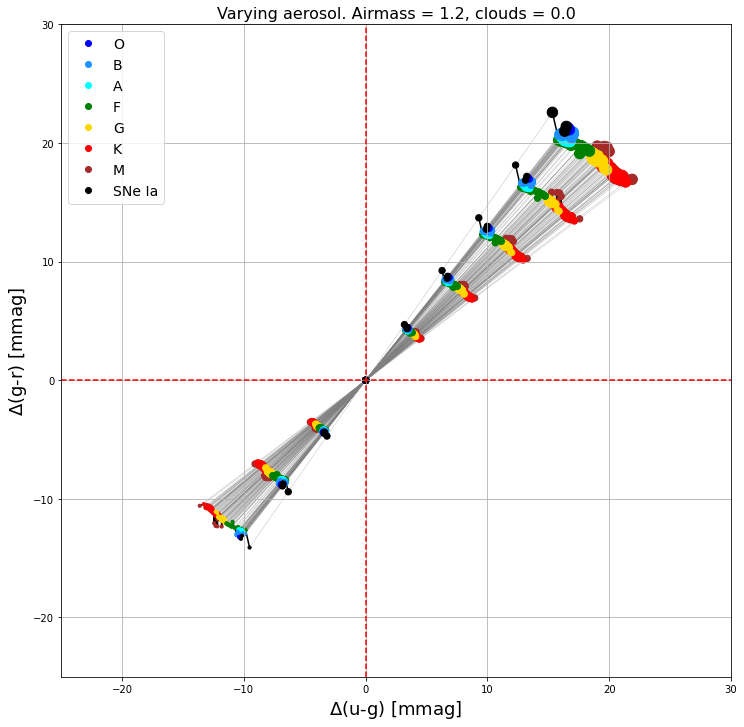

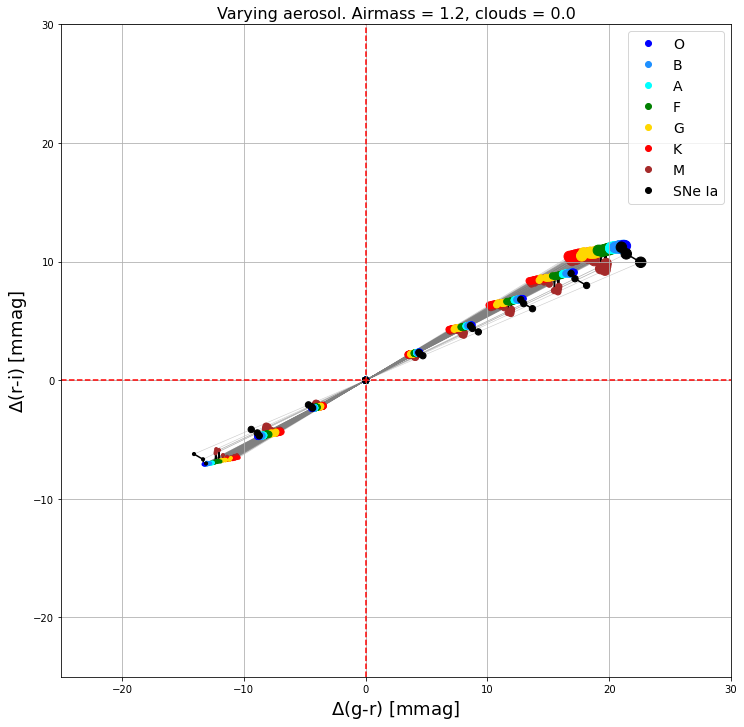

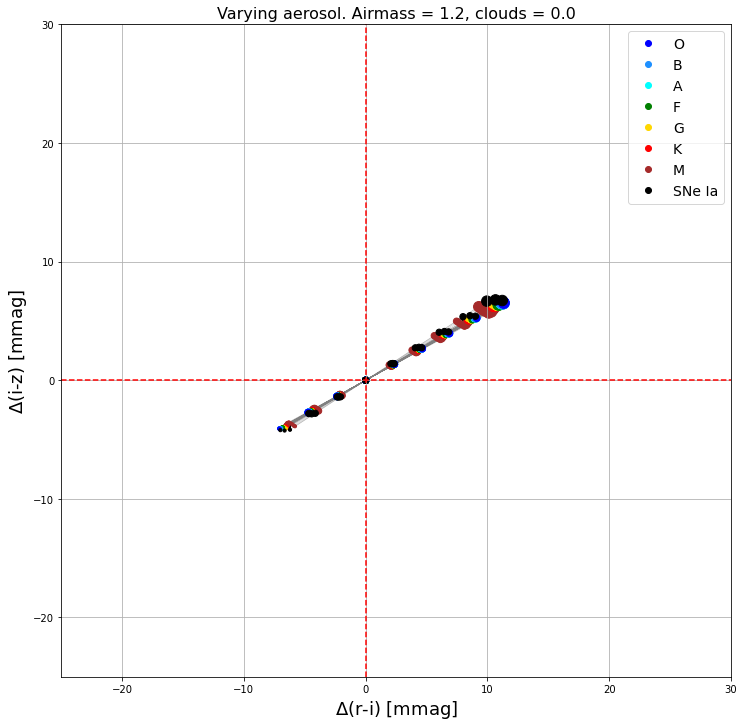

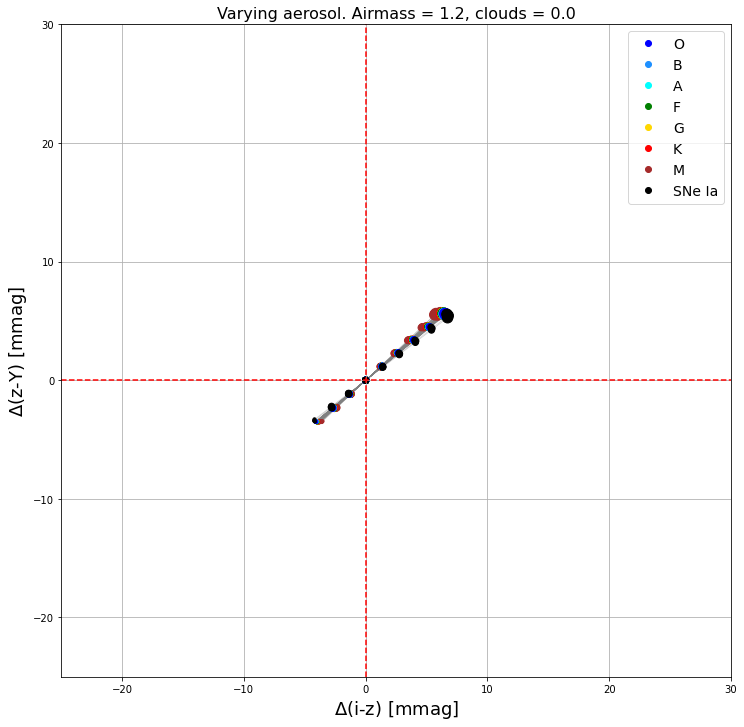

In [207]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(12,12))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex2)
        axs.set_ylim(rangey2)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))

This is just the same but interchanging the axes 

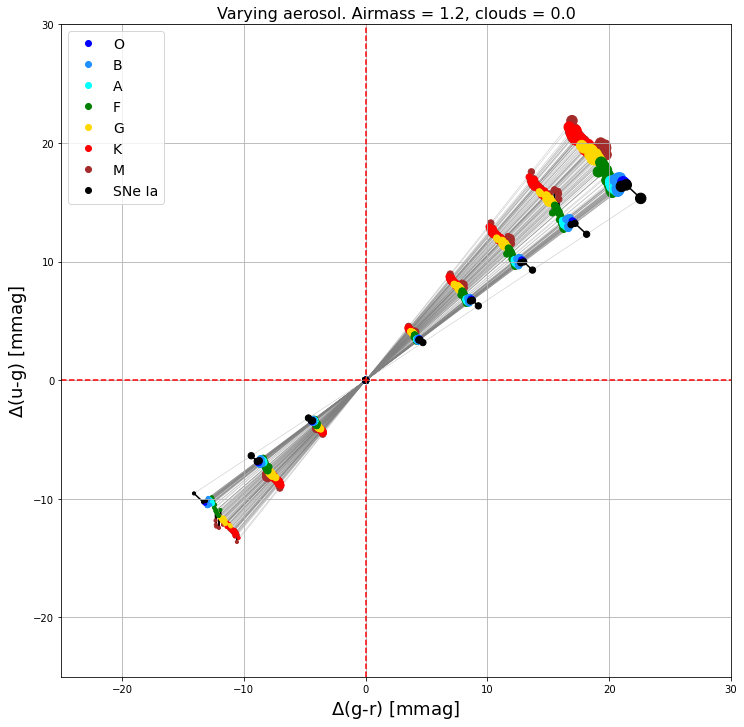

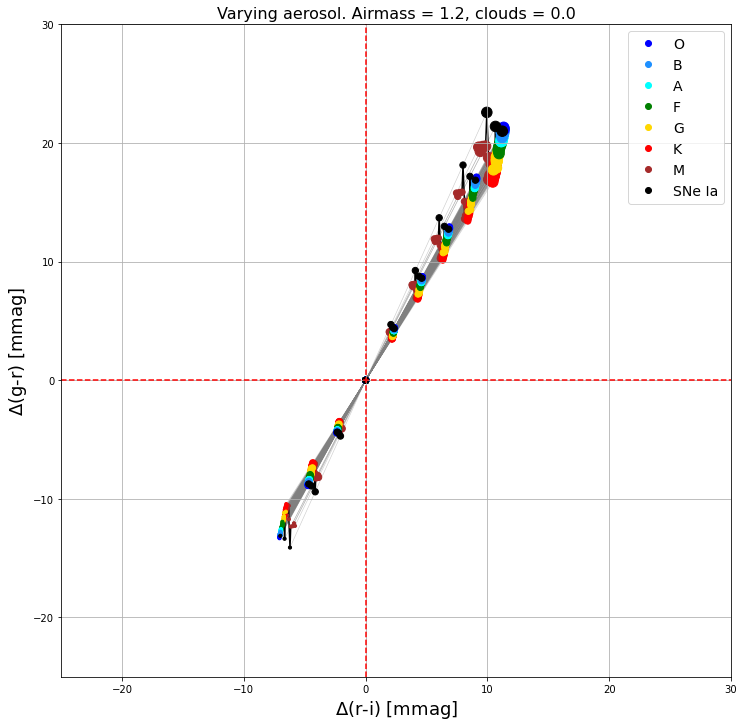

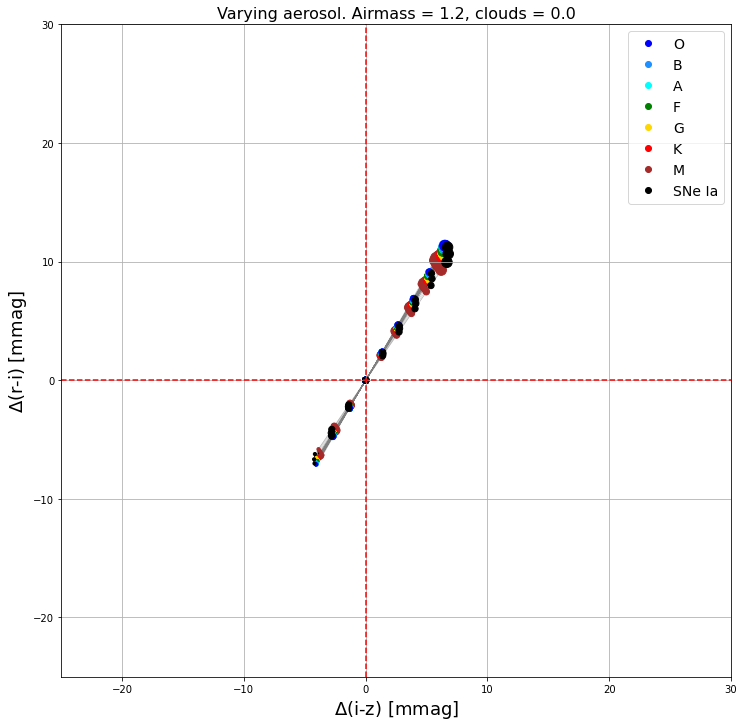

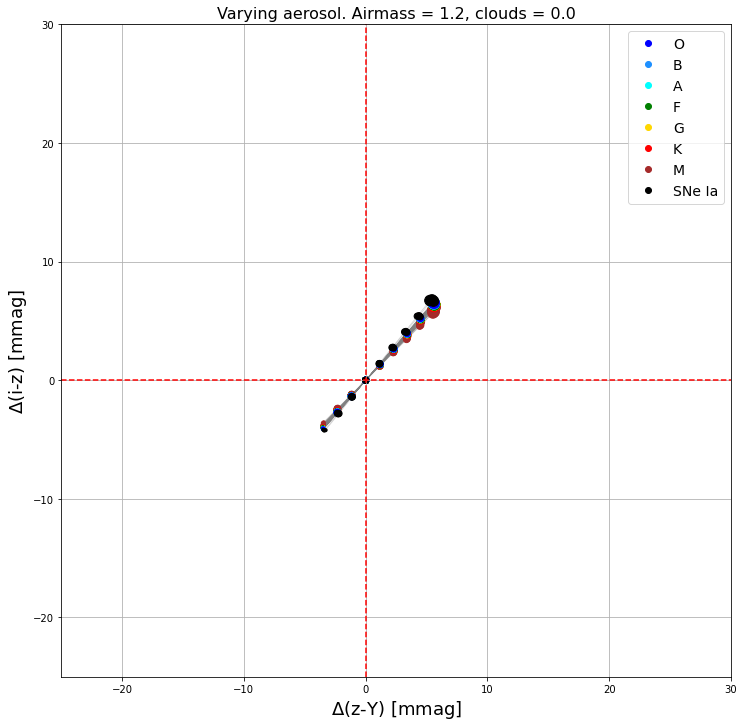

In [206]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(12,12))
    if i<len(filters)-2:
        cy = '{0}-{1}'.format(filters[i],filters[i+1])
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangey2)
        axs.set_ylim(rangex2)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))